# VAE 모델

## 목적
- 낚시를 성공했을 때의 기상, 해양 데이터들의 특징, 패턴을 학습하여 새로운 데이터와 얼마나 유사한지. 낚시터의 점수를 제공하기 위함

## 데이터 전처리
1. 각 변수들 간의 상관관계를 분석 후 사용할 변수를 선정
    - 중복 정보를 가지는 중복 변수를 제거하여 노이즈 제거 및 과적합 방지
2. VIF를 통해 독립 변수에 대한 다변수 선형관계를 파악
    - 상관관계에서 파악하지 못한 다변수간의 관계를 파악하여 중복 정보를 파악
3. 상호작용 변수 생성을 통한 도메인 지식 제공
    - 도메인 지식을 정용하여 모델이 학습하기 어려운 비선형적인 내용을 수식으로 제공
    - 상호작용 변수 생성을 통해 VIF 점수를 낮춰 중복 정보 방지.
4. 선택된 데이터들의 주기적 특성을 반영한 sin/cos 인코딩
    - 물때, 시간, 계절과 같은 주기적인 특성을 모델이 파악할 수 있도록 인코딩 후 제공하여 정보 손실 방지


## 데이터 학습
- 학습 진행 시, 각 변수들을 선택하여 어떤 변수들이 예측에 도움이 되는지 파악

## 결과
- ELBO 값을 이용하여 현재 낚시터의 기상, 해양 데이터를 이용한 점수를 제공할 수 있다는 것을 파악
- 95% 퍼센타일의 임계점을 기준으로 5.2%라는 결과를 달성하여 이상치 탐지 성능을 확인함

## 한계점
- 학습된 데이터들의 특징과 패턴을 이용하여 점수를 제공한 것이기 때문에 학습하지 못한 성공적인 날씨와 지역에 대해서는 이상치로 판단을 하여 유사도 점수가 낮아짐
    - 해결법: 실제 사용자들의 데이터 수집하여 모델을 점진적으로 개선
- 정량적 성능 지표의 부재
    - KL_D와 ELBO, MSE, 95 퍼센타일의 결과를 기반으로 성능을 판단
    - 하지만 실제로 어떤 모델이 제대로된 실제 성능을 제공할 수 있는지에 대한 객관적인 지표의 부재.
    - 해결법: 정량적 성능 지표 탐색.

In [18]:
import joblib
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from typing import List, Tuple, Dict, Optional
from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    # elif torch.backends.mps.is_available():
    #     return torch.device("mps")
    else:
        return torch.device("cpu")
    
def setup_korean_font():
    """한국어 폰트 설정"""
    try:
        font_path = "/System/Library/Fonts/AppleSDGothicNeo.ttc"
        font_name = fm.FontProperties(fname=font_path, size=12).get_name()
        plt.rc('font', family=font_name)
        print(f"한국어 폰트 '{font_name}' 설정 완료")
    except FileNotFoundError:
        print("한국어 폰트를 찾을 수 없습니다. 기본 폰트 사용")

def heatmap(df: pd.DataFrame, title: str = 'Correlation Heatmap'):
    """상관관계 히트맵 시각화"""
    plt.figure(figsize=(12, 10))
    corr = df.corr()
    plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def find_highly_correlated_features(df: pd.DataFrame, threshold: float = 0.9) -> set:
    """높은 상관관계를 가진 피처 쌍 찾기"""
    corr_matrix = df.corr().abs()
    highly_correlated_pairs = set()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                highly_correlated_pairs.add((colname, corr_matrix.columns[j], corr_matrix.iloc[i, j]))
    
    return highly_correlated_pairs

def calculate_vif(df: pd.DataFrame) -> pd.DataFrame:
    """분산팽창인수(VIF) 계산"""
    numeric_df = df.select_dtypes(include=np.number).dropna()
    
    numeric_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    numeric_df.dropna(inplace=True)

    constant_cols = [col for col in numeric_df.columns if numeric_df[col].nunique() <= 1]
    if constant_cols:
        numeric_df = numeric_df.drop(columns=constant_cols)

    if numeric_df.shape[1] < 2:
        return pd.DataFrame(columns=['Feature', 'VIF', 'priority_score'])

    vif_data = pd.DataFrame()
    vif_data["Feature"] = numeric_df.columns
    
    vif_values = []
    for i in range(numeric_df.shape[1]):
        try:
            vif = variance_inflation_factor(numeric_df.values, i)
        except Exception:
            vif = np.inf
        vif_values.append(vif)
        
    vif_data["VIF"] = vif_values

    vif_data['priority_score'] = vif_data['VIF'].apply(
        lambda x: 0 if np.isinf(x) else
                  1 if x >= 50 else
                  2 if x >= 20 else
                  3 if x >= 10 else
                  4 if x >= 5 else 5
    )

    vif_result = vif_data.sort_values('VIF', ascending=False).reset_index(drop=True)
    
    return vif_result

def analyze_data_correlation(df: pd.DataFrame, title_prefix: str = "데이터"):
    """데이터 상관관계 종합 분석"""
    print(f"\n{'='*60}")
    print(f"{title_prefix} 상관관계 분석")
    print(f"{'='*60}")
    
    df_numeric = df.select_dtypes(include=np.number)
    
    print(f"수치형 변수 개수: {len(df_numeric.columns)}")
    print(f"수치형 변수: {list(df_numeric.columns)}")
    
    heatmap(df_numeric, title=f'{title_prefix} Correlation Heatmap')
    
    highly_correlated_features = find_highly_correlated_features(df_numeric, threshold=0.7)
    print(f"\n높은 상관관계 피처 쌍 (threshold=0.7):")
    if highly_correlated_features:
        for pair in sorted(highly_correlated_features, key=lambda x: abs(x[2]), reverse=True):
            print(f"  {pair[0]} ↔ {pair[1]}: {pair[2]:.3f}")
    else:
        print("  발견된 높은 상관관계 쌍이 없습니다.")
    
    moderate_corr_features = find_highly_correlated_features(df_numeric, threshold=0.3)
    print(f"\n중간 수준 상관관계 피처 쌍 (threshold=0.3):")
    if moderate_corr_features:
        moderate_only = moderate_corr_features - highly_correlated_features
        for pair in sorted(moderate_only, key=lambda x: abs(x[2]), reverse=True):
            print(f"  {pair[0]} ↔ {pair[1]}: {pair[2]:.3f}")
    else:
        print("  발견된 중간 수준 상관관계 쌍이 없습니다.")
    
    print(f"\nVIF (분산팽창인수) 분석:")
    vif_result = calculate_vif(df_numeric)
    if not vif_result.empty:
        print(vif_result.to_string(index=False))
        
        high_vif = vif_result[vif_result['VIF'] >= 10]
        if not high_vif.empty:
            print(f"\n⚠️  높은 VIF 값 (≥10) 변수들:")
            for _, row in high_vif.iterrows():
                print(f"  {row['Feature']}: {row['VIF']:.2f}")
        else:
            print(f"\n✅ 모든 변수의 VIF가 10 미만입니다.")
    else:
        print("  VIF 계산을 위한 충분한 데이터가 없습니다.")
    
    return {
        'numeric_df': df_numeric,
        'high_corr': highly_correlated_features,
        'moderate_corr': moderate_corr_features,
        'vif_result': vif_result
    }

class VAE(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 32, latent_dim: int = 4):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
        self.relu = nn.ReLU()

    def encode(self, x):
        h = self.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def decode(self, z):
        h = self.relu(self.fc2(z))
        return self.fc3(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

def compute_pca_weights(X: np.ndarray) -> torch.Tensor:
    """PCA 가중치 계산"""
    pca = PCA(n_components=min(X.shape[1], 5))
    pca.fit(X)
    feature_importance = np.abs(pca.components_)
    weights = np.sum(feature_importance, axis=0)
    weights = weights * (len(weights) / np.sum(weights))
    return torch.tensor(weights, dtype=torch.float32)

def weighted_mse_loss(recon_x: torch.Tensor, x: torch.Tensor, weight_vector: Optional[torch.Tensor] = None) -> torch.Tensor:
    """가중치 적용 MSE 손실 함수"""
    if weight_vector is None:
        return F.mse_loss(recon_x, x, reduction='none').sum(dim=1)
    else:
        weight_vector = weight_vector.to(recon_x.device)
        squared_error = (recon_x - x) ** 2
        weighted_error = squared_error * weight_vector.unsqueeze(0)
        return torch.sum(weighted_error, dim=1)

def vae_loss(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor, 
             beta: float = 1.0, weight_vector: Optional[torch.Tensor] = None) -> torch.Tensor:
    """VAE 손실 함수"""
    recon_loss_per_sample = weighted_mse_loss(recon_x, x, weight_vector)
    kl_loss_per_sample = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    total_loss = (recon_loss_per_sample + beta * kl_loss_per_sample).mean()
    return total_loss

def prepare_data(df: pd.DataFrame, interaction_terms: List[Tuple[str, str]], 
                 base_features: List[str]) -> Tuple[np.ndarray, np.ndarray, List[str], SimpleImputer, StandardScaler]:
    """데이터 전처리 및 교호변수 생성"""
    df_processed = df.copy()
    
    feature_cols = []
    
    for term1, term2 in interaction_terms:
        if term1 not in df_processed.columns or term2 not in df_processed.columns:
            raise ValueError(f"교호변수 생성 실패: {term1} 또는 {term2} 컬럼이 없습니다")
        
        interaction_name = f"{term1}_x_{term2}"
        df_processed[interaction_name] = df_processed[term1] * df_processed[term2]
        feature_cols.append(interaction_name)
    
    feature_cols.extend(base_features)
    
    missing_features = [col for col in feature_cols if col not in df_processed.columns]
    if missing_features:
        raise ValueError(f"누락된 피처: {missing_features}")
    
    df_features = df_processed[feature_cols].copy()
    
    imputer = SimpleImputer(strategy="mean")
    X_raw = df_features.values.astype(np.float32)
    X_filled = imputer.fit_transform(X_raw)
    
    X_trainval, X_test = train_test_split(X_filled, test_size=0.05, random_state=42, shuffle=True)
    
    scaler = StandardScaler()
    X_trainval_scaled = scaler.fit_transform(X_trainval)
    X_test_scaled = scaler.transform(X_test)
    
    return X_trainval_scaled, X_test_scaled, feature_cols, imputer, scaler

def train_vae_kfold(X_trainval: np.ndarray, feature_cols: List[str], 
                   n_splits: int = 3, num_epochs: int = 100, batch_size: int = 16,
                   learning_rate: float = 1e-4, beta: float = 0.3, hidden_dim: int = 32,
                   latent_dim: int = 4, early_stop_patience: int = 10, 
                   use_weights: bool = True) -> Dict:
    """K-Fold VAE 훈련"""
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    input_dim = X_trainval.shape[1]
    device = get_device()
    
    if use_weights:
        feature_weights = compute_pca_weights(X_trainval)
        print("피처별 가중치:")
        for i, (col, weight) in enumerate(zip(feature_cols, feature_weights)):
            print(f"{col}: {weight:.4f}")
    else:
        feature_weights = None
    
    fold_recon_errors = []
    fold_train_losses = []
    fold_val_losses = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_trainval)):
        print(f"\n--- Fold {fold_idx+1} / {n_splits} ---")
        
        X_tr = X_trainval[train_idx]
        X_val = X_trainval[val_idx]
        
        X_tr_tensor = torch.tensor(X_tr, dtype=torch.float32).to(device)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
        
        train_dataset = torch.utils.data.TensorDataset(X_tr_tensor, X_tr_tensor)
        val_dataset = torch.utils.data.TensorDataset(X_val_tensor, X_val_tensor)
        
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        model = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        train_loss_history = []
        val_loss_history = []
        best_val_loss = float('inf')
        epochs_no_improve = 0
        best_model_state_dict = None
        
        for epoch in range(num_epochs):
            model.train()
            batch_train_losses = []
            for batch_x, _ in train_loader:
                optimizer.zero_grad()
                recon_x, mu, logvar = model(batch_x)
                loss = vae_loss(recon_x, batch_x, mu, logvar, beta=beta, weight_vector=feature_weights)
                loss.backward()
                optimizer.step()
                batch_train_losses.append(loss.item())
            train_loss_avg = np.mean(batch_train_losses)
            
            model.eval()
            batch_val_losses = []
            with torch.no_grad():
                for batch_x, _ in val_loader:
                    recon_x, mu, logvar = model(batch_x)
                    loss = vae_loss(recon_x, batch_x, mu, logvar, beta=beta, weight_vector=feature_weights)
                    batch_val_losses.append(loss.item())
            val_loss_avg = np.mean(batch_val_losses)
            
            train_loss_history.append(train_loss_avg)
            val_loss_history.append(val_loss_avg)
            
            if val_loss_avg < best_val_loss:
                best_val_loss = val_loss_avg
                best_model_state_dict = model.state_dict()
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            
            if epochs_no_improve >= early_stop_patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        fold_train_losses.append(train_loss_history)
        fold_val_losses.append(val_loss_history)
        
        if best_model_state_dict is not None:
            model.load_state_dict(best_model_state_dict)
        
        model.eval()
        with torch.no_grad():
            recon_val, _, _ = model(X_val_tensor)
            recon_val_np = recon_val.cpu().numpy()
            X_val_np = X_val_tensor.cpu().numpy()
        
        mse_each = np.mean((X_val_np - recon_val_np)**2, axis=1)
        fold_mse = np.mean(mse_each)
        print(f"Fold {fold_idx+1} 검증 재구성 오차: {fold_mse:.6f}")
        fold_recon_errors.append(fold_mse)
    
    cv_mean_error = np.mean(fold_recon_errors)
    print(f"\nK-Fold 평균 검증 재구성 오차: {cv_mean_error:.6f}")
    
    return {
        'cv_mean_error': cv_mean_error,
        'fold_train_losses': fold_train_losses,
        'fold_val_losses': fold_val_losses,
        'feature_weights': feature_weights
    }

def train_final_vae(X_trainval: np.ndarray, feature_weights: Optional[torch.Tensor],
                   num_epochs: int = 100, batch_size: int = 16, learning_rate: float = 1e-4,
                   beta: float = 0.3, hidden_dim: int = 32, latent_dim: int = 4,
                   early_stop_patience: int = 10) -> VAE:
    """최종 VAE 모델 훈련"""
    
    input_dim = X_trainval.shape[1]
    device = get_device()
    
    X_final_train, X_final_val = train_test_split(X_trainval, test_size=0.1, random_state=42, shuffle=True)
    
    X_final_train_tensor = torch.tensor(X_final_train, dtype=torch.float32).to(device)
    X_final_val_tensor = torch.tensor(X_final_val, dtype=torch.float32).to(device)
    
    trainval_dataset = torch.utils.data.TensorDataset(X_final_train_tensor, X_final_train_tensor)
    val_dataset = torch.utils.data.TensorDataset(X_final_val_tensor, X_final_val_tensor)
    
    trainval_loader = torch.utils.data.DataLoader(trainval_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    final_model = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
    optimizer = optim.Adam(final_model.parameters(), lr=learning_rate)
    
    best_val_loss_final = float('inf')
    epochs_no_improve_final = 0
    best_model_state_dict_final = None
    
    print("\n최종 모델 훈련 시작")
    for epoch in range(num_epochs):
        final_model.train()
        batch_train_losses = []
        for batch_x, _ in trainval_loader:
            optimizer.zero_grad()
            recon_x, mu, logvar = final_model(batch_x)
            loss = vae_loss(recon_x, batch_x, mu, logvar, beta=beta, weight_vector=feature_weights)
            loss.backward()
            optimizer.step()
            batch_train_losses.append(loss.item())
        
        final_model.eval()
        batch_val_losses = []
        with torch.no_grad():
            for batch_x, _ in val_loader:
                recon_x, mu, logvar = final_model(batch_x)
                loss = vae_loss(recon_x, batch_x, mu, logvar, beta=beta, weight_vector=feature_weights)
                batch_val_losses.append(loss.item())
        
        val_loss_avg = np.mean(batch_val_losses)
        
        if val_loss_avg < best_val_loss_final:
            best_val_loss_final = val_loss_avg
            best_model_state_dict_final = final_model.state_dict()
            epochs_no_improve_final = 0
        else:
            epochs_no_improve_final += 1
        
        if epochs_no_improve_final >= early_stop_patience:
            print(f"최종 모델 조기 종료: epoch {epoch+1}")
            break
    
    if best_model_state_dict_final is not None:
        final_model.load_state_dict(best_model_state_dict_final)
    
    return final_model

def evaluate_model(model: VAE, X_test: np.ndarray, feature_weights: Optional[torch.Tensor],
                  beta: float = 0.3) -> Dict:
    """모델 성능 평가"""
    
    device = get_device()
    model.to(device)
    
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    model.eval()
    
    with torch.no_grad():
        recon_test, mu_test, logvar_test = model(X_test_tensor)
        recon_test_np = recon_test.cpu().numpy()
        mu_test_np = mu_test.cpu().numpy()
        logvar_test_np = logvar_test.cpu().numpy()
    
    recon_errors = np.mean((X_test - recon_test_np)**2, axis=1)
    test_recon_error_mean_mse = np.mean(recon_errors)
    
    kl_losses = -0.5 * np.sum(1 + logvar_test_np - mu_test_np**2 - np.exp(logvar_test_np), axis=1)
    test_kl_loss_mean = np.mean(kl_losses)
    
    if feature_weights is not None:
        weighted_squared_error_test = (X_test - recon_test_np)**2 * feature_weights.cpu().numpy().reshape(1, -1)
        recon_errors_weighted_test = np.sum(weighted_squared_error_test, axis=1)
        elbo_rows = recon_errors_weighted_test + beta * kl_losses
    else:
        elbo_rows = recon_errors + beta * kl_losses
    
    test_elbo_mean = np.mean(elbo_rows)
    
    min_elbo = elbo_rows.min()
    max_elbo = elbo_rows.max()
    
    if max_elbo == min_elbo:
        elbo_scores = np.ones_like(elbo_rows)
    else:
        elbo_scores = 1 - (elbo_rows - min_elbo) / (max_elbo - min_elbo)
        elbo_scores = np.clip(elbo_scores, 0, 1)
    
    threshold = np.percentile(elbo_rows, 95)
    abnormal_flags = elbo_rows > threshold
    
    return {
        'test_recon_error_mean_mse': test_recon_error_mean_mse,
        'test_kl_loss_mean': test_kl_loss_mean,
        'test_elbo_mean': test_elbo_mean,
        'elbo_rows': elbo_rows,
        'elbo_scores': elbo_scores,
        'min_elbo': min_elbo,
        'max_elbo': max_elbo,
        'threshold': threshold,
        'abnormal_flags': abnormal_flags,
        'mu_test_np': mu_test_np,
        'recon_errors': recon_errors,
        'kl_losses': kl_losses
    }

def visualize_results(evaluation_results: Dict, experiment_name: str):
    """결과 시각화"""
    
    elbo_rows = evaluation_results['elbo_rows']
    mu_test_np = evaluation_results['mu_test_np']
    recon_errors = evaluation_results['recon_errors']
    kl_losses = evaluation_results['kl_losses']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    scatter = axes[0, 0].scatter(mu_test_np[:, 0], mu_test_np[:, 1], c=elbo_rows, cmap='viridis_r', alpha=0.7, s=10)
    axes[0, 0].set_title(f'{experiment_name} - 잠재 공간 시각화')
    axes[0, 0].set_xlabel('Latent Dimension 1')
    axes[0, 0].set_ylabel('Latent Dimension 2')
    axes[0, 0].grid(True, linestyle='--', alpha=0.7)
    plt.colorbar(scatter, ax=axes[0, 0], label='ELBO')
    
    axes[0, 1].hist(recon_errors, bins=50, alpha=0.7, color='blue', density=True)
    recon_err_threshold = np.percentile(recon_errors, 95)
    axes[0, 1].axvline(x=recon_err_threshold, color='red', linestyle='--', 
                      label=f'95% 임계값 ({recon_err_threshold:.4f})')
    axes[0, 1].set_title(f'{experiment_name} - 재구성 오차 분포')
    axes[0, 1].set_xlabel('재구성 오차 (MSE)')
    axes[0, 1].set_ylabel('밀도')
    axes[0, 1].legend()
    axes[0, 1].grid(True, axis='y', linestyle='--', alpha=0.5)
    
    kl_vis_threshold = np.percentile(kl_losses, 99)
    kl_losses_vis = kl_losses[kl_losses < kl_vis_threshold]
    axes[1, 0].hist(kl_losses_vis, bins=50, alpha=0.7, color='green', density=True)
    kl_loss_threshold = np.percentile(kl_losses, 95)
    axes[1, 0].axvline(x=kl_loss_threshold, color='red', linestyle='--', 
                      label=f'95% 임계값 ({kl_loss_threshold:.4f})')
    axes[1, 0].set_title(f'{experiment_name} - KL 손실 분포')
    axes[1, 0].set_xlabel('KL 손실')
    axes[1, 0].set_ylabel('밀도')
    axes[1, 0].legend()
    axes[1, 0].grid(True, axis='y', linestyle='--', alpha=0.5)
    
    axes[1, 1].hist(elbo_rows, bins=50, alpha=0.7, color='purple', density=True)
    elbo_threshold = evaluation_results['threshold']
    axes[1, 1].axvline(x=elbo_threshold, color='red', linestyle='--', 
                      label=f'95% 임계값 ({elbo_threshold:.4f})')
    axes[1, 1].set_title(f'{experiment_name} - ELBO 분포')
    axes[1, 1].set_xlabel('ELBO')
    axes[1, 1].set_ylabel('밀도')
    axes[1, 1].legend()
    axes[1, 1].grid(True, axis='y', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

def save_model_and_results(model: VAE, imputer: SimpleImputer, scaler: StandardScaler,
                          evaluation_results: Dict, experiment_name: str):
    """모델 및 결과 저장"""
    
    os.makedirs("./models", exist_ok=True)
    
    model_path = f"./models/{experiment_name}_vae_model.pth"
    imputer_path = f"./models/{experiment_name}_imputer.pkl"
    scaler_path = f"./models/{experiment_name}_scaler.pkl"
    
    torch.save(model.to('cpu').state_dict(), model_path)
    joblib.dump(imputer, imputer_path)
    joblib.dump(scaler, scaler_path)
    
    print(f"모델 저장 완료: {model_path}")
    print(f"전처리 객체 저장 완료: {imputer_path}, {scaler_path}")

def run_vae_experiment(df: pd.DataFrame, interaction_terms: List[Tuple[str, str]], 
                      base_features: List[str], experiment_name: str, 
                      use_weights: bool = True, **kwargs) -> Dict:
    """VAE 실험 실행"""
    
    print(f"\n{'='*50}")
    print(f"실험명: {experiment_name}")
    print(f"교호변수: {interaction_terms}")
    print(f"기본 피처: {base_features}")
    print(f"가중치 사용: {use_weights}")
    print(f"{'='*50}")
    
    try:
        X_trainval, X_test, feature_cols, imputer, scaler = prepare_data(
            df, interaction_terms, base_features
        )
        
        print(f"피처 개수: {len(feature_cols)}")
        print(f"훈련 데이터 크기: {X_trainval.shape}")
        print(f"테스트 데이터 크기: {X_test.shape}")
        
        kfold_results = train_vae_kfold(
            X_trainval, feature_cols, use_weights=use_weights, **kwargs
        )
        
        final_model = train_final_vae(
            X_trainval, kfold_results['feature_weights'], **kwargs
        )
        
        evaluation_results = evaluate_model(
            final_model, X_test, kfold_results['feature_weights'], 
            beta=kwargs.get('beta', 0.3)
        )
        
        print(f"\n{experiment_name} 성능 요약:")
        print(f"평균 재구성 오차: {evaluation_results['test_recon_error_mean_mse']:.6f}")
        print(f"평균 KL 손실: {evaluation_results['test_kl_loss_mean']:.6f}")
        print(f"평균 ELBO: {evaluation_results['test_elbo_mean']:.6f}")
        print(f"이상치 탐지율: {sum(evaluation_results['abnormal_flags'])}/{len(evaluation_results['abnormal_flags'])} ({sum(evaluation_results['abnormal_flags'])/len(evaluation_results['abnormal_flags'])*100:.2f}%)")
        
        visualize_results(evaluation_results, experiment_name)
        
        save_model_and_results(final_model, imputer, scaler, evaluation_results, experiment_name)
        
        return {
            'experiment_name': experiment_name,
            'interaction_terms': interaction_terms,
            'base_features': base_features,
            'feature_cols': feature_cols,
            'kfold_results': kfold_results,
            'evaluation_results': evaluation_results,
            'model': final_model,
            'imputer': imputer,
            'scaler': scaler
        }
        
    except Exception as e:
        print(f"실험 실행 중 오류 발생: {str(e)}")
        return None

def compare_experiments(experiment_results: List[Dict]):
    """실험 결과 비교"""
    
    if not experiment_results:
        print("비교할 실험 결과가 없습니다.")
        return
    
    print("\n" + "="*80)
    print("실험 결과 비교")
    print("="*80)
    
    comparison_data = []
    for result in experiment_results:
        if result is None:
            continue
            
        eval_results = result['evaluation_results']
        comparison_data.append({
            '실험명': result['experiment_name'],
            '교호변수': str(result['interaction_terms']),
            '피처 수': len(result['feature_cols']),
            '재구성 오차': eval_results['test_recon_error_mean_mse'],
            'KL 손실': eval_results['test_kl_loss_mean'],
            'ELBO': eval_results['test_elbo_mean'],
            '이상치 수': sum(eval_results['abnormal_flags']),
            '이상치 비율(%)': sum(eval_results['abnormal_flags'])/len(eval_results['abnormal_flags'])*100
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
    
    best_elbo_idx = comparison_df['ELBO'].idxmin()
    best_experiment = comparison_df.iloc[best_elbo_idx]
    
    print(f"\n최적 실험 (최소 ELBO): {best_experiment['실험명']}")
    print(f"ELBO: {best_experiment['ELBO']:.6f}")
    print(f"교호변수: {best_experiment['교호변수']}")
    
    return comparison_df

def comprehensive_data_analysis_and_vae(df: pd.DataFrame, 
                                       feature_combinations: List[List[str]] = None,
                                       experiment_names: List[str] = None) -> Dict:
    """데이터 분석 + VAE 실험 통합 함수"""
    
    setup_korean_font()
    
    print("데이터 상관관계 분석 시작")
    correlation_analysis = analyze_data_correlation(df, "전체 데이터")
    
    if feature_combinations is None:
        feature_combinations = [
            ["tmp_x_sea_temp", "ws_x_wh_sig", "weather_REH", "wvprd_max", "wvdr", "wd"],
            ["weather_TMP", "matched_sea_temp", "ws", "wh_sig"],
            ["weather_REH", "wvprd_max", "wvdr", "wd"],
            ["weather_TMP", "matched_sea_temp", "weather_REH"]
        ]
    
    if experiment_names is None:
        experiment_names = [f"실험_{i+1}" for i in range(len(feature_combinations))]
    
    print("\nVAE 이상 탐지 실험 시작")
    vae_comparison = compare_feature_combinations(df, feature_combinations, experiment_names)
    
    return {
        'correlation_analysis': correlation_analysis,
        'vae_results': vae_comparison,
        'feature_combinations': feature_combinations,
        'experiment_names': experiment_names
    }

def run_complete_vae_analysis(df: pd.DataFrame, user_feature_cols: List[str] = None, 
                             experiment_name: str = "VAE_분석", use_weights: bool = True,
                             num_epochs: int = 100, batch_size: int = 16, 
                             learning_rate: float = 1e-4, beta: float = 0.3,
                             hidden_dim: int = 32, latent_dim: int = 4,
                             early_stop_patience: int = 10, n_splits: int = 3) -> Dict:
    """완전한 VAE 분석 실행 함수"""
    
    setup_korean_font()
    
    if user_feature_cols is None:
        required_cols = ["weather_TMP", "matched_sea_temp", "ws", "wh_sig"]
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns in CSV for interaction terms: {missing_cols}")
        
        df_processed = df.copy()
        df_processed["tmp_x_sea_temp"] = df_processed["weather_TMP"] * df_processed["matched_sea_temp"]
        df_processed["ws_x_wh_sig"] = df_processed["ws"] * df_processed["wh_sig"]
        
        feature_cols = [
            "tmp_x_sea_temp",
            "ws_x_wh_sig", 
            "weather_REH",
            "wvprd_max",
            "wvdr",
            "wd"
        ]
    else:
        df_processed = df.copy()
        feature_cols = user_feature_cols
    
    missing_features = [col for col in feature_cols if col not in df_processed.columns]
    if missing_features:
        raise ValueError(f"Missing selected feature columns in CSV: {missing_features}")
    
    print(f"\n{'='*60}")
    print(f"VAE 이상 탐지 분석 시작: {experiment_name}")
    print(f"사용 피처: {feature_cols}")
    print(f"가중치 사용: {use_weights}")
    print(f"{'='*60}")
    
    df_features = df_processed[feature_cols].copy()
    
    imputer = SimpleImputer(strategy="mean")
    X_raw = df_features.values.astype(np.float32)
    X_filled = imputer.fit_transform(X_raw)
    
    X_trainval, X_test = train_test_split(X_filled, test_size=0.05, random_state=42, shuffle=True)
    
    scaler = StandardScaler()
    X_trainval_scaled = scaler.fit_transform(X_trainval)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"데이터 형태 - 훈련: {X_trainval_scaled.shape}, 테스트: {X_test_scaled.shape}")
    
    input_dim = X_trainval_scaled.shape[1]
    device = get_device()
    print(f"사용 디바이스: {device}")
    
    if use_weights:
        feature_weights = compute_pca_weights(X_trainval_scaled)
        print("\n피처별 가중치:")
        for i, (col, weight) in enumerate(zip(feature_cols, feature_weights)):
            print(f"  {col}: {weight:.4f}")
    else:
        feature_weights = None
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_recon_errors = []
    fold_train_losses = []
    fold_val_losses = []
    
    print(f"\nK-Fold 교차 검증 시작 (k={n_splits})")
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_trainval_scaled)):
        print(f"\n--- Fold {fold_idx+1} / {n_splits} ---")
        
        X_tr = X_trainval_scaled[train_idx]
        X_val = X_trainval_scaled[val_idx]
        
        X_tr_tensor = torch.tensor(X_tr, dtype=torch.float32).to(device)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
        
        train_dataset = torch.utils.data.TensorDataset(X_tr_tensor, X_tr_tensor)
        val_dataset = torch.utils.data.TensorDataset(X_val_tensor, X_val_tensor)
        
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        model = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        train_loss_history = []
        val_loss_history = []
        best_val_loss = float('inf')
        epochs_no_improve = 0
        best_model_state_dict = None
        
        for epoch in range(num_epochs):
            model.train()
            batch_train_losses = []
            for batch_x, _ in train_loader:
                optimizer.zero_grad()
                recon_x, mu, logvar = model(batch_x)
                loss = vae_loss(recon_x, batch_x, mu, logvar, beta=beta, weight_vector=feature_weights)
                loss.backward()
                optimizer.step()
                batch_train_losses.append(loss.item())
            train_loss_avg = np.mean(batch_train_losses)
            
            model.eval()
            batch_val_losses = []
            with torch.no_grad():
                for batch_x, _ in val_loader:
                    recon_x, mu, logvar = model(batch_x)
                    loss = vae_loss(recon_x, batch_x, mu, logvar, beta=beta, weight_vector=feature_weights)
                    batch_val_losses.append(loss.item())
            val_loss_avg = np.mean(batch_val_losses)
            
            train_loss_history.append(train_loss_avg)
            val_loss_history.append(val_loss_avg)
            
            if (epoch+1) % 20 == 0:
                print(f"  Epoch {epoch+1}/{num_epochs} - Train: {train_loss_avg:.4f}, Val: {val_loss_avg:.4f}")
            
            if val_loss_avg < best_val_loss:
                best_val_loss = val_loss_avg
                best_model_state_dict = model.state_dict()
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            
            if epochs_no_improve >= early_stop_patience:
                print(f"  조기 종료: epoch {epoch+1}")
                break
        
        fold_train_losses.append(train_loss_history)
        fold_val_losses.append(val_loss_history)
        
        if best_model_state_dict is not None:
            model.load_state_dict(best_model_state_dict)
        
        model.eval()
        with torch.no_grad():
            recon_val, _, _ = model(X_val_tensor)
            recon_val_np = recon_val.cpu().numpy()
            X_val_np = X_val_tensor.cpu().numpy()
        
        mse_each = np.mean((X_val_np - recon_val_np)**2, axis=1)
        fold_mse = np.mean(mse_each)
        print(f"  Fold {fold_idx+1} 검증 재구성 오차: {fold_mse:.6f}")
        fold_recon_errors.append(fold_mse)
    
    cv_mean_error = np.mean(fold_recon_errors)
    print(f"\nK-Fold 평균 검증 재구성 오차: {cv_mean_error:.6f}")
    
    plt.figure(figsize=(12, 5))
    for i in range(n_splits):
        plt.plot(range(len(fold_train_losses[i])), fold_train_losses[i], label=f"Fold{i+1}_Train", alpha=0.7)
        plt.plot(range(len(fold_val_losses[i])), fold_val_losses[i], '--', label=f"Fold{i+1}_Val", alpha=0.7)
    plt.title(f"{experiment_name} - K-Fold 훈련/검증 손실")
    plt.xlabel("Epoch")
    plt.ylabel("손실")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print("\n최종 모델 훈련 시작")
    X_final_train, X_final_val = train_test_split(X_trainval_scaled, test_size=0.1, random_state=42, shuffle=True)
    
    X_final_train_tensor = torch.tensor(X_final_train, dtype=torch.float32).to(device)
    X_final_val_tensor = torch.tensor(X_final_val, dtype=torch.float32).to(device)
    
    trainval_dataset = torch.utils.data.TensorDataset(X_final_train_tensor, X_final_train_tensor)
    val_dataset = torch.utils.data.TensorDataset(X_final_val_tensor, X_final_val_tensor)
    
    trainval_loader = torch.utils.data.DataLoader(trainval_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    final_model = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
    optimizer = optim.Adam(final_model.parameters(), lr=learning_rate)
    
    train_loss_history_final = []
    val_loss_history_final = []
    best_val_loss_final = float('inf')
    epochs_no_improve_final = 0
    best_model_state_dict_final = None
    
    for epoch in range(num_epochs):
        final_model.train()
        batch_train_losses = []
        for batch_x, _ in trainval_loader:
            optimizer.zero_grad()
            recon_x, mu, logvar = final_model(batch_x)
            loss = vae_loss(recon_x, batch_x, mu, logvar, beta=beta, weight_vector=feature_weights)
            loss.backward()
            optimizer.step()
            batch_train_losses.append(loss.item())
        train_loss_avg = np.mean(batch_train_losses)
        
        final_model.eval()
        batch_val_losses = []
        with torch.no_grad():
            for batch_x, _ in val_loader:
                recon_x, mu, logvar = final_model(batch_x)
                loss = vae_loss(recon_x, batch_x, mu, logvar, beta=beta, weight_vector=feature_weights)
                batch_val_losses.append(loss.item())
        val_loss_avg = np.mean(batch_val_losses)
        
        train_loss_history_final.append(train_loss_avg)
        val_loss_history_final.append(val_loss_avg)
        
        if (epoch+1) % 20 == 0:
            print(f"  Epoch {epoch+1}/{num_epochs} - Train: {train_loss_avg:.4f}, Val: {val_loss_avg:.4f}")
        
        if val_loss_avg < best_val_loss_final:
            best_val_loss_final = val_loss_avg
            best_model_state_dict_final = final_model.state_dict()
            epochs_no_improve_final = 0
        else:
            epochs_no_improve_final += 1
        
        if epochs_no_improve_final >= early_stop_patience:
            print(f"  최종 모델 조기 종료: epoch {epoch+1}")
            break
    
    if best_model_state_dict_final is not None:
        final_model.load_state_dict(best_model_state_dict_final)
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history_final, label='훈련 손실', alpha=0.8)
    plt.plot(val_loss_history_final, label='검증 손실', alpha=0.8)
    plt.title(f'{experiment_name} - 최종 모델 훈련 곡선')
    plt.xlabel('Epoch')
    plt.ylabel('손실')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print("\n테스트 데이터 평가 시작")
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
    final_model.eval()
    
    with torch.no_grad():
        recon_test, mu_test, logvar_test = final_model(X_test_tensor)
        recon_test_np = recon_test.cpu().numpy()
        mu_test_np = mu_test.cpu().numpy()
        logvar_test_np = logvar_test.cpu().numpy()
    
    recon_errors = np.mean((X_test_scaled - recon_test_np)**2, axis=1)
    test_recon_error_mean_mse = np.mean(recon_errors)
    
    kl_losses = -0.5 * np.sum(1 + logvar_test_np - mu_test_np**2 - np.exp(logvar_test_np), axis=1)
    test_kl_loss_mean = np.mean(kl_losses)
    
    if feature_weights is not None:
        weighted_squared_error_test = (X_test_scaled - recon_test_np)**2 * feature_weights.cpu().numpy().reshape(1, -1)
        recon_errors_weighted_test = np.sum(weighted_squared_error_test, axis=1)
        elbo_rows = recon_errors_weighted_test + beta * kl_losses
    else:
        elbo_rows = recon_errors + beta * kl_losses
    
    test_elbo_mean = np.mean(elbo_rows)
    
    min_elbo = elbo_rows.min()
    max_elbo = elbo_rows.max()
    
    if max_elbo == min_elbo:
        elbo_scores = np.ones_like(elbo_rows)
    else:
        elbo_scores = 1 - (elbo_rows - min_elbo) / (max_elbo - min_elbo)
        elbo_scores = np.clip(elbo_scores, 0, 1)
    
    threshold = np.percentile(elbo_rows, 95)
    abnormal_flags = elbo_rows > threshold
    
    print(f"\n{'='*50}")
    print(f"{experiment_name} - 최종 성능 요약")
    print(f"{'='*50}")
    print(f"테스트 데이터 평균 재구성 오차 (MSE): {test_recon_error_mean_mse:.6f}")
    print(f"테스트 데이터 평균 KL 손실: {test_kl_loss_mean:.6f}")
    print(f"테스트 데이터 평균 ELBO: {test_elbo_mean:.6f}")
    print(f"이상치 탐지 임계값 (95 퍼센타일): {threshold:.6f}")
    print(f"탐지된 이상치 수: {sum(abnormal_flags)}/{len(abnormal_flags)} ({sum(abnormal_flags)/len(abnormal_flags)*100:.2f}%)")
    
    print(f"\n샘플 ELBO 점수 (처음 5개):")
    for i in range(min(5, len(elbo_scores))):
        print(f"  테스트 #{i+1} -> ELBO: {elbo_rows[i]:.4f}, 점수: {elbo_scores[i]:.4f}")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    scatter = axes[0, 0].scatter(mu_test_np[:, 0], mu_test_np[:, 1], c=elbo_rows, cmap='viridis_r', alpha=0.7, s=10)
    axes[0, 0].set_title(f'{experiment_name} - 잠재 공간 시각화')
    axes[0, 0].set_xlabel('잠재 차원 1')
    axes[0, 0].set_ylabel('잠재 차원 2')
    axes[0, 0].grid(True, linestyle='--', alpha=0.7)
    plt.colorbar(scatter, ax=axes[0, 0], label='ELBO (낮을수록 정상)')
    
    axes[0, 1].hist(recon_errors, bins=50, alpha=0.7, color='blue', density=True)
    recon_err_threshold = np.percentile(recon_errors, 95)
    axes[0, 1].axvline(x=recon_err_threshold, color='red', linestyle='--', 
                      label=f'95% 임계값 ({recon_err_threshold:.4f})')
    axes[0, 1].set_title('재구성 오차 분포 (MSE)')
    axes[0, 1].set_xlabel('재구성 오차')
    axes[0, 1].set_ylabel('밀도')
    axes[0, 1].legend()
    axes[0, 1].grid(True, axis='y', linestyle='--', alpha=0.5)
    
    kl_vis_threshold = np.percentile(kl_losses, 99)
    kl_losses_vis = kl_losses[kl_losses < kl_vis_threshold]
    axes[1, 0].hist(kl_losses_vis, bins=50, alpha=0.7, color='green', density=True)
    kl_loss_threshold = np.percentile(kl_losses, 95)
    axes[1, 0].axvline(x=kl_loss_threshold, color='red', linestyle='--', 
                      label=f'95% 임계값 ({kl_loss_threshold:.4f})')
    axes[1, 0].set_title('KL 손실 분포 (상위 1% 제외)')
    axes[1, 0].set_xlabel('KL 손실')
    axes[1, 0].set_ylabel('밀도')
    axes[1, 0].legend()
    axes[1, 0].grid(True, axis='y', linestyle='--', alpha=0.5)
    
    axes[1, 1].hist(elbo_rows, bins=50, alpha=0.7, color='purple', density=True)
    axes[1, 1].axvline(x=threshold, color='red', linestyle='--', 
                      label=f'95% 임계값 ({threshold:.4f})')
    axes[1, 1].set_title('ELBO 분포')
    axes[1, 1].set_xlabel('ELBO')
    axes[1, 1].set_ylabel('밀도')
    axes[1, 1].legend()
    axes[1, 1].grid(True, axis='y', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    os.makedirs("./models", exist_ok=True)
    model_path = f"./models/{experiment_name}_vae_model.pth"
    imputer_path = f"./models/{experiment_name}_imputer.pkl"
    scaler_path = f"./models/{experiment_name}_scaler.pkl"
    
    torch.save(final_model.to('cpu').state_dict(), model_path)
    joblib.dump(imputer, imputer_path)
    joblib.dump(scaler, scaler_path)
    
    print(f"\n모델 저장 완료:")
    print(f"  - 모델: {model_path}")
    print(f"  - 전처리 객체: {imputer_path}, {scaler_path}")
    
    df_processed_copy = df_processed.copy()
    X_all_raw = df_processed_copy[feature_cols].values.astype(np.float32)
    X_all_filled = imputer.transform(X_all_raw)
    X_all_scaled = scaler.transform(X_all_filled)
    X_all_tensor = torch.tensor(X_all_scaled, dtype=torch.float32).to(device)
    
    final_model.to(device)
    final_model.eval()
    with torch.no_grad():
        recon_all, mu_all, logvar_all = final_model(X_all_tensor)
    
    recon_all_np = recon_all.cpu().numpy()
    mu_all_np = mu_all.cpu().numpy()
    logvar_all_np = logvar_all.cpu().numpy()
    
    errors_all = np.mean((X_all_scaled - recon_all_np)**2, axis=1)
    kl_all = -0.5 * np.sum(1 + logvar_all_np - mu_all_np**2 - np.exp(logvar_all_np), axis=1)
    
    if feature_weights is not None:
        weighted_sq_err_all = (X_all_scaled - recon_all_np)**2 * feature_weights.cpu().numpy().reshape(1, -1)
        recon_err_weighted_all = np.sum(weighted_sq_err_all, axis=1)
        elbo_all = recon_err_weighted_all + beta * kl_all
    else:
        elbo_all = errors_all + beta * kl_all
    
    if max_elbo == min_elbo:
        score_all = np.ones_like(elbo_all)
    else:
        score_all = 1 - (elbo_all - min_elbo) / (max_elbo - min_elbo)
        score_all = np.clip(score_all, 0, 1)
    
    df_processed_copy["reconstruction_error_mse"] = errors_all
    df_processed_copy["kl_loss"] = kl_all
    df_processed_copy["elbo"] = elbo_all
    df_processed_copy["elbo_score_0to1"] = score_all
    
    result_path = f"./result_{experiment_name}.csv"
    df_processed_copy.to_csv(result_path, index=False, encoding='utf-8-sig')
    print(f"  - 결과 파일: {result_path}")
    
    return {
        'experiment_name': experiment_name,
        'feature_cols': feature_cols,
        'cv_mean_error': cv_mean_error,
        'test_recon_error_mean_mse': test_recon_error_mean_mse,
        'test_kl_loss_mean': test_kl_loss_mean,
        'test_elbo_mean': test_elbo_mean,
        'threshold': threshold,
        'anomaly_count': sum(abnormal_flags),
        'anomaly_rate': sum(abnormal_flags)/len(abnormal_flags)*100,
        'model': final_model,
        'imputer': imputer,
        'scaler': scaler,
        'feature_weights': feature_weights,
        'elbo_scores': elbo_scores,
        'result_df': df_processed_copy
    }

def compare_feature_combinations(df: pd.DataFrame, feature_combinations: List[List[str]], 
                               experiment_names: List[str] = None) -> pd.DataFrame:
    """여러 피처 조합 비교 실험"""
    
    if experiment_names is None:
        experiment_names = [f"실험_{i+1}" for i in range(len(feature_combinations))]
    
    results = []
    all_experiment_results = []
    
    for i, (features, exp_name) in enumerate(zip(feature_combinations, experiment_names)):
        print(f"\n{i+1}/{len(feature_combinations)} 실험 진행 중...")
        
        try:
            result = run_complete_vae_analysis(
                df=df,
                user_feature_cols=features,
                experiment_name=exp_name,
                use_weights=True
            )
            
            results.append({
                '실험명': exp_name,
                '피처 조합': str(features),
                '피처 수': len(features),
                '평균 재구성 오차': result['test_recon_error_mean_mse'],
                '평균 KL 손실': result['test_kl_loss_mean'],
                '평균 ELBO': result['test_elbo_mean'],
                '이상치 수': result['anomaly_count'],
                '이상치 비율(%)': result['anomaly_rate']
            })
            
            all_experiment_results.append(result)
            
        except Exception as e:
            print(f"실험 {exp_name} 실행 중 오류: {str(e)}")
            continue
    
    if not results:
        print("성공한 실험이 없습니다.")
        return None
    
    comparison_df = pd.DataFrame(results)
    
    print("\n" + "="*100)
    print("실험 결과 비교")
    print("="*100)
    print(comparison_df.to_string(index=False))
    
    best_elbo_idx = comparison_df['평균 ELBO'].idxmin()
    best_experiment = comparison_df.iloc[best_elbo_idx]
    
    print(f"\n최적 실험 (최소 ELBO): {best_experiment['실험명']}")
    print(f"  - 평균 ELBO: {best_experiment['평균 ELBO']:.6f}")
    print(f"  - 피처 조합: {best_experiment['피처 조합']}")
    print(f"  - 이상치 탐지율: {best_experiment['이상치 비율(%)']:.2f}%")
    
    return comparison_df

### 각 변수 별 영향 확인
- 변수 추가 진행을 통한 결과 값 확인 : KL_D, MSE
- 상호작용 변수 추가


1/7 실험 진행 중...
한국어 폰트 'Apple SD Gothic Neo' 설정 완료

VAE 이상 탐지 분석 시작: corr + VIF 점수 기반 변수 삭제 후 선택된 변수들
사용 피처: ['weather_TMP', 'matched_sea_temp', 'ws', 'wh_sig', 'weather_REH', 'wvprd_max', 'wvdr', 'wd']
가중치 사용: True
데이터 형태 - 훈련: (6504, 8), 테스트: (343, 8)
사용 디바이스: cpu

피처별 가중치:
  weather_TMP: 0.9508
  matched_sea_temp: 0.8864
  ws: 1.0274
  wh_sig: 0.6523
  weather_REH: 1.1209
  wvprd_max: 1.3019
  wvdr: 1.0406
  wd: 1.0198

K-Fold 교차 검증 시작 (k=3)

--- Fold 1 / 3 ---
  Epoch 20/100 - Train: 4.4311, Val: 3.9745
  Epoch 40/100 - Train: 3.7157, Val: 3.2393
  Epoch 60/100 - Train: 3.5248, Val: 3.0331
  Epoch 80/100 - Train: 3.4450, Val: 2.9622
  Epoch 100/100 - Train: 3.3919, Val: 2.9143
  Fold 1 검증 재구성 오차: 0.184161

--- Fold 2 / 3 ---
  Epoch 20/100 - Train: 4.1478, Val: 3.4754
  Epoch 40/100 - Train: 3.7775, Val: 3.1640
  Epoch 60/100 - Train: 3.6557, Val: 3.0421
  Epoch 80/100 - Train: 3.5443, Val: 2.9480
  Epoch 100/100 - Train: 3.4953, Val: 2.8928
  Fold 2 검증 재구성 오차: 0.190084

--- Fold 3

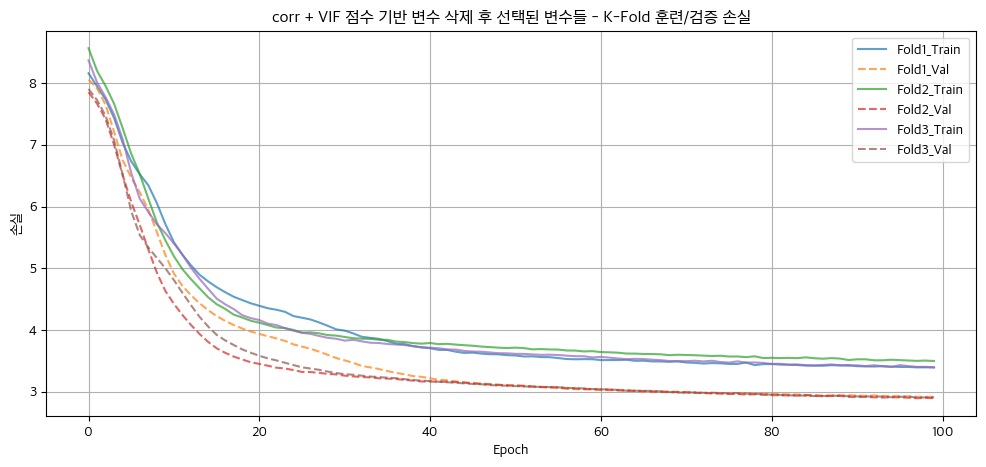


최종 모델 훈련 시작
  Epoch 20/100 - Train: 3.8887, Val: 3.3238
  Epoch 40/100 - Train: 3.6214, Val: 3.0716
  Epoch 60/100 - Train: 3.4971, Val: 2.9468
  Epoch 80/100 - Train: 3.4407, Val: 2.9010
  Epoch 100/100 - Train: 3.3812, Val: 2.8550


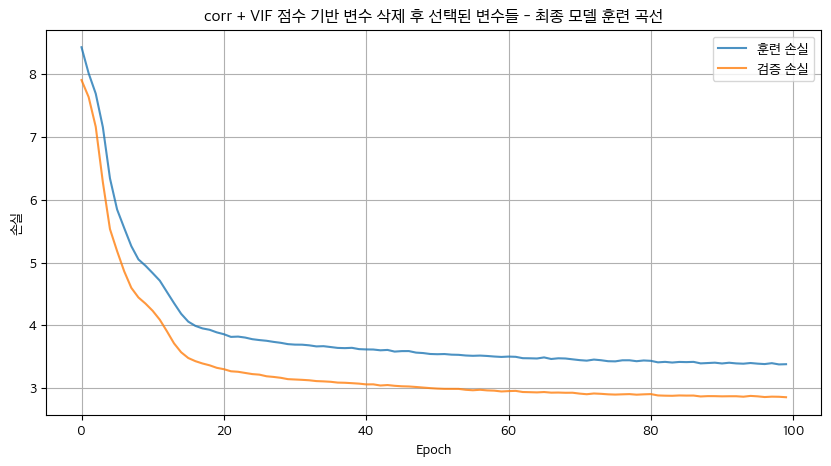


테스트 데이터 평가 시작

corr + VIF 점수 기반 변수 삭제 후 선택된 변수들 - 최종 성능 요약
테스트 데이터 평균 재구성 오차 (MSE): 0.178715
테스트 데이터 평균 KL 손실: 4.908630
테스트 데이터 평균 ELBO: 2.886108
이상치 탐지 임계값 (95 퍼센타일): 5.468122
탐지된 이상치 수: 18/343 (5.25%)

샘플 ELBO 점수 (처음 5개):
  테스트 #1 -> ELBO: 2.7479, 점수: 0.7927
  테스트 #2 -> ELBO: 4.0595, 점수: 0.6349
  테스트 #3 -> ELBO: 5.9584, 점수: 0.4064
  테스트 #4 -> ELBO: 6.3352, 점수: 0.3610
  테스트 #5 -> ELBO: 2.9213, 점수: 0.7718


/var/folders/9g/km8p2t5105l95qr48nycb7xh0000gn/T/ipykernel_3922/806145218.py:1009: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Apple SD Gothic Neo.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniforge/base/envs/311/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Apple SD Gothic Neo.
  fig.canvas.print_figure(bytes_io, **kw)


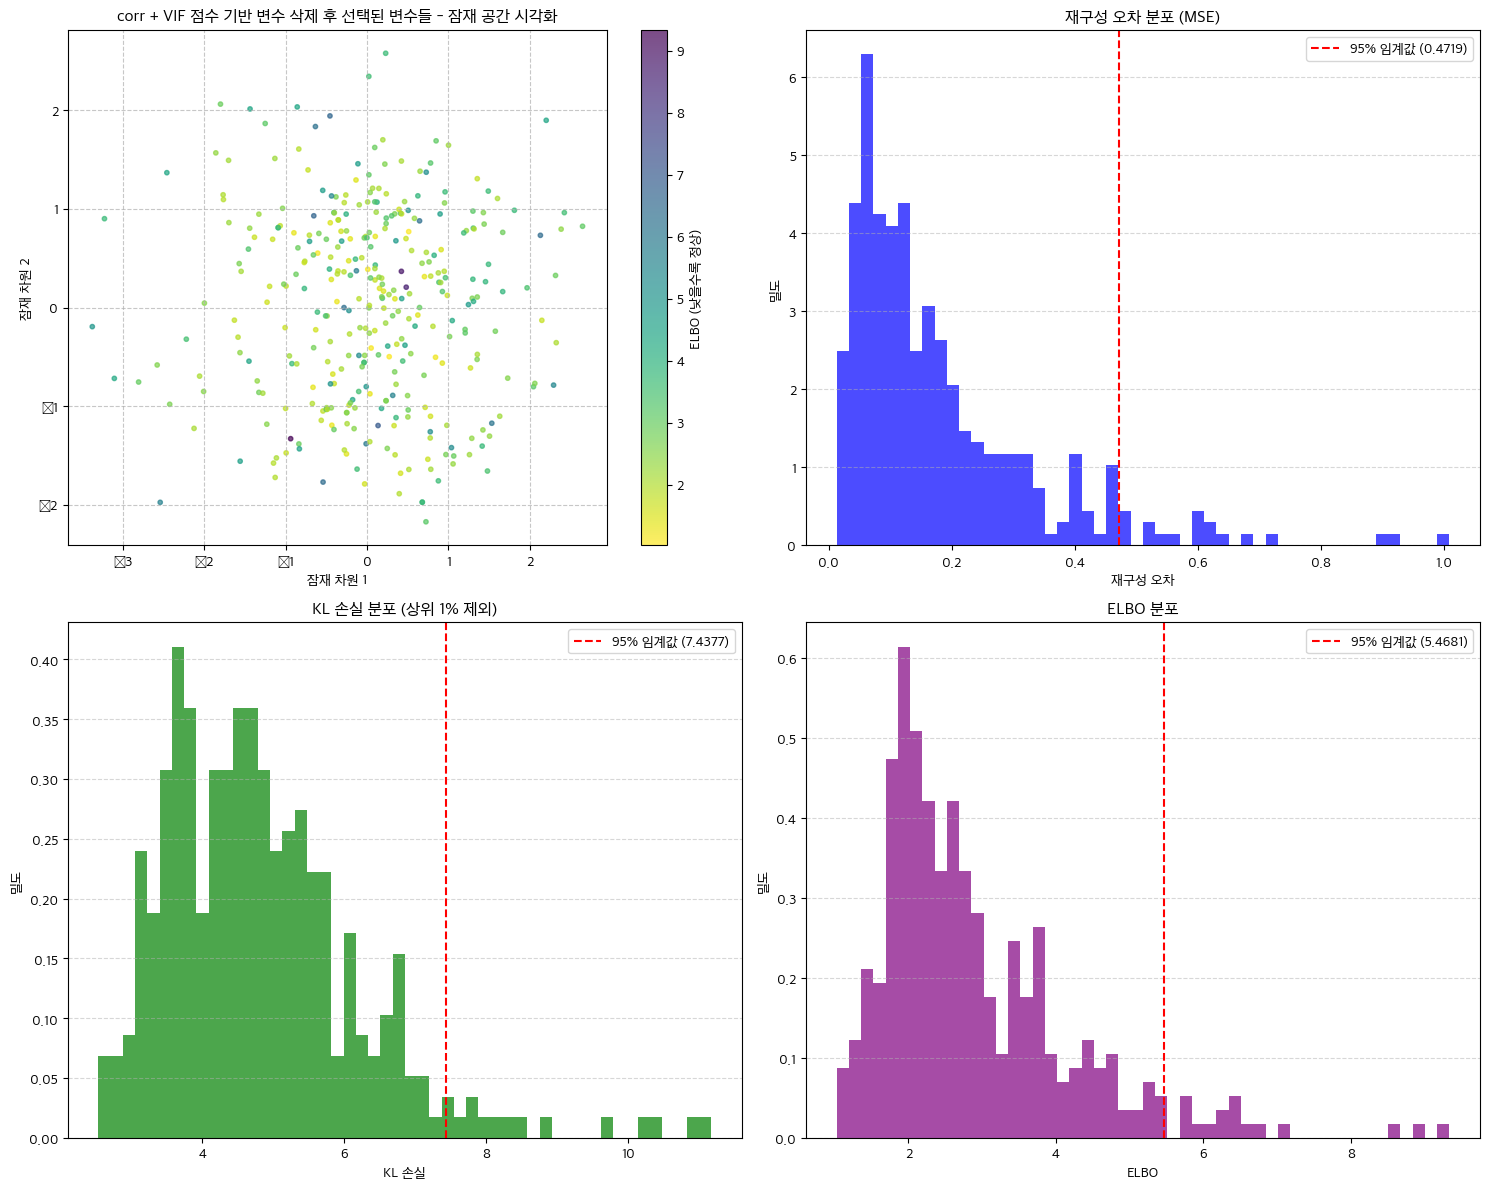


모델 저장 완료:
  - 모델: ./models/corr + VIF 점수 기반 변수 삭제 후 선택된 변수들_vae_model.pth
  - 전처리 객체: ./models/corr + VIF 점수 기반 변수 삭제 후 선택된 변수들_imputer.pkl, ./models/corr + VIF 점수 기반 변수 삭제 후 선택된 변수들_scaler.pkl
  - 결과 파일: ./result_corr + VIF 점수 기반 변수 삭제 후 선택된 변수들.csv

2/7 실험 진행 중...
한국어 폰트 'Apple SD Gothic Neo' 설정 완료

VAE 이상 탐지 분석 시작: 상호 작용 변수 생성
사용 피처: ['tmp_x_sea_temp', 'ws_x_wh_sig', 'weather_REH', 'wvprd_max', 'wvdr', 'wd']
가중치 사용: True
데이터 형태 - 훈련: (6504, 6), 테스트: (343, 6)
사용 디바이스: cpu

피처별 가중치:
  tmp_x_sea_temp: 0.8349
  ws_x_wh_sig: 1.0096
  weather_REH: 0.7977
  wvprd_max: 1.1379
  wvdr: 1.1372
  wd: 1.0827

K-Fold 교차 검증 시작 (k=3)

--- Fold 1 / 3 ---
  Epoch 20/100 - Train: 3.0477, Val: 2.6373
  Epoch 40/100 - Train: 2.6986, Val: 2.2297
  Epoch 60/100 - Train: 2.6261, Val: 2.1386
  Epoch 80/100 - Train: 2.5917, Val: 2.1053
  Epoch 100/100 - Train: 2.5498, Val: 2.0772
  Fold 1 검증 재구성 오차: 0.142806

--- Fold 2 / 3 ---
  Epoch 20/100 - Train: 2.9327, Val: 2.3255
  Epoch 40/100 - Train: 2.6556, Val:

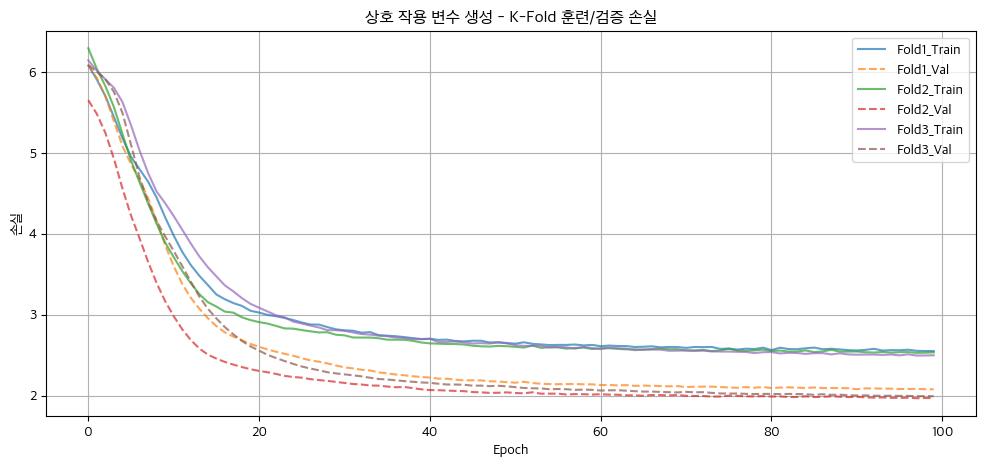


최종 모델 훈련 시작
  Epoch 20/100 - Train: 2.8071, Val: 2.2900
  Epoch 40/100 - Train: 2.5916, Val: 2.0546
  Epoch 60/100 - Train: 2.5240, Val: 1.9959
  Epoch 80/100 - Train: 2.5057, Val: 1.9843
  Epoch 100/100 - Train: 2.4897, Val: 1.9646


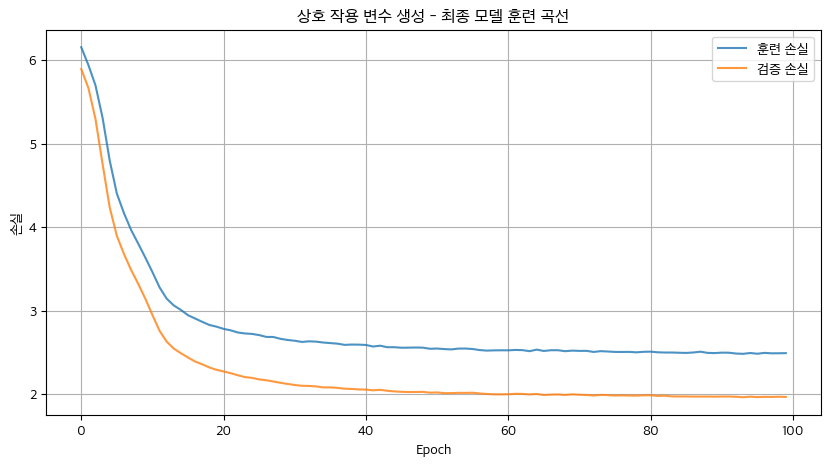


테스트 데이터 평가 시작

상호 작용 변수 생성 - 최종 성능 요약
테스트 데이터 평균 재구성 오차 (MSE): 0.132543
테스트 데이터 평균 KL 손실: 4.294357
테스트 데이터 평균 ELBO: 2.043138
이상치 탐지 임계값 (95 퍼센타일): 3.855300
탐지된 이상치 수: 18/343 (5.25%)

샘플 ELBO 점수 (처음 5개):
  테스트 #1 -> ELBO: 2.1503, 점수: 0.7968
  테스트 #2 -> ELBO: 2.7527, 점수: 0.7022
  테스트 #3 -> ELBO: 2.9818, 점수: 0.6662
  테스트 #4 -> ELBO: 2.5847, 점수: 0.7286
  테스트 #5 -> ELBO: 1.7651, 점수: 0.8573


/var/folders/9g/km8p2t5105l95qr48nycb7xh0000gn/T/ipykernel_3922/806145218.py:1009: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Apple SD Gothic Neo.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniforge/base/envs/311/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Apple SD Gothic Neo.
  fig.canvas.print_figure(bytes_io, **kw)


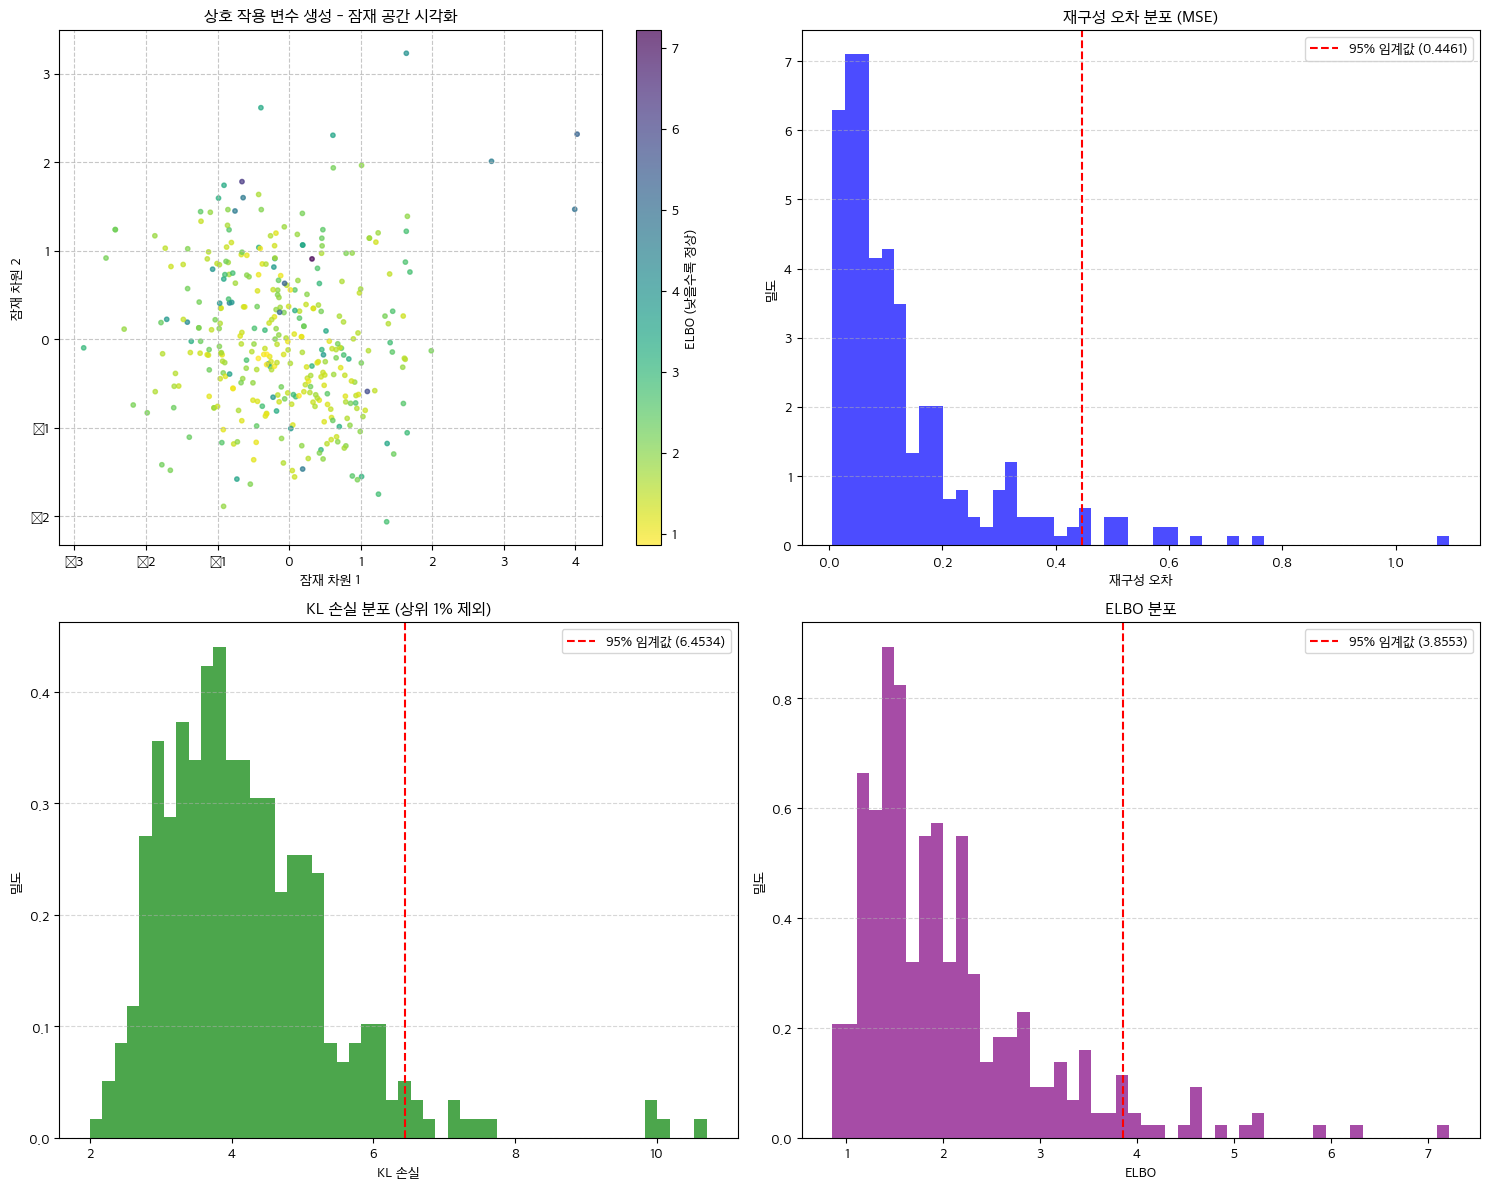


모델 저장 완료:
  - 모델: ./models/상호 작용 변수 생성_vae_model.pth
  - 전처리 객체: ./models/상호 작용 변수 생성_imputer.pkl, ./models/상호 작용 변수 생성_scaler.pkl
  - 결과 파일: ./result_상호 작용 변수 생성.csv

3/7 실험 진행 중...
한국어 폰트 'Apple SD Gothic Neo' 설정 완료

VAE 이상 탐지 분석 시작: 물때 적용
사용 피처: ['tmp_x_sea_temp', 'ws_x_wh_sig', 'weather_REH', 'wvprd_max', 'wvdr', 'wd', 'mul_tte_code']
가중치 사용: True
데이터 형태 - 훈련: (6504, 7), 테스트: (343, 7)
사용 디바이스: cpu

피처별 가중치:
  tmp_x_sea_temp: 0.9195
  ws_x_wh_sig: 1.2159
  weather_REH: 0.9284
  wvprd_max: 1.0784
  wvdr: 0.9217
  wd: 0.8650
  mul_tte_code: 1.0711

K-Fold 교차 검증 시작 (k=3)

--- Fold 1 / 3 ---
  Epoch 20/100 - Train: 3.8733, Val: 3.5316
  Epoch 40/100 - Train: 3.5034, Val: 3.1118
  Epoch 60/100 - Train: 3.3371, Val: 2.9261
  Epoch 80/100 - Train: 3.2498, Val: 2.8194
  Epoch 100/100 - Train: 3.2044, Val: 2.7615
  Fold 1 검증 재구성 오차: 0.205101

--- Fold 2 / 3 ---
  Epoch 20/100 - Train: 3.9348, Val: 3.2783
  Epoch 40/100 - Train: 3.5081, Val: 2.9181
  Epoch 60/100 - Train: 3.3701, Val: 2.7824

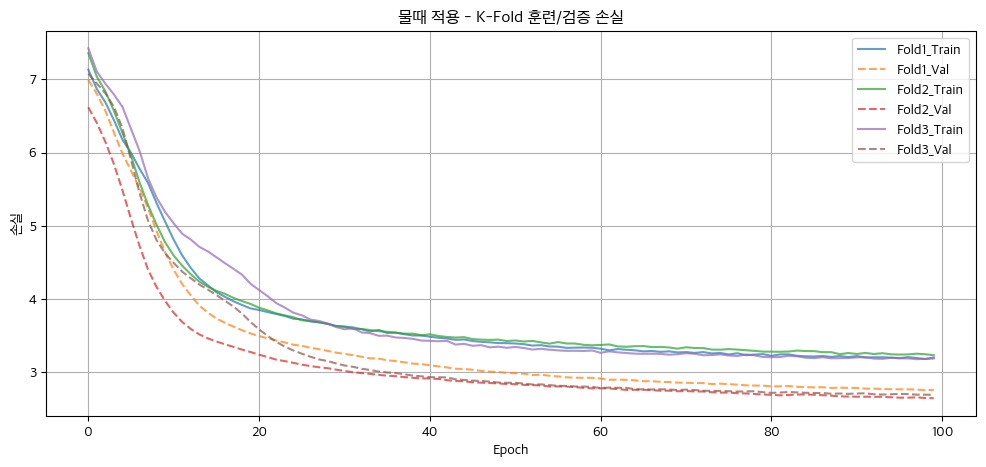


최종 모델 훈련 시작
  Epoch 20/100 - Train: 3.7188, Val: 3.2496
  Epoch 40/100 - Train: 3.4561, Val: 2.9660
  Epoch 60/100 - Train: 3.3518, Val: 2.8540
  Epoch 80/100 - Train: 3.2862, Val: 2.7822
  Epoch 100/100 - Train: 3.2241, Val: 2.7164


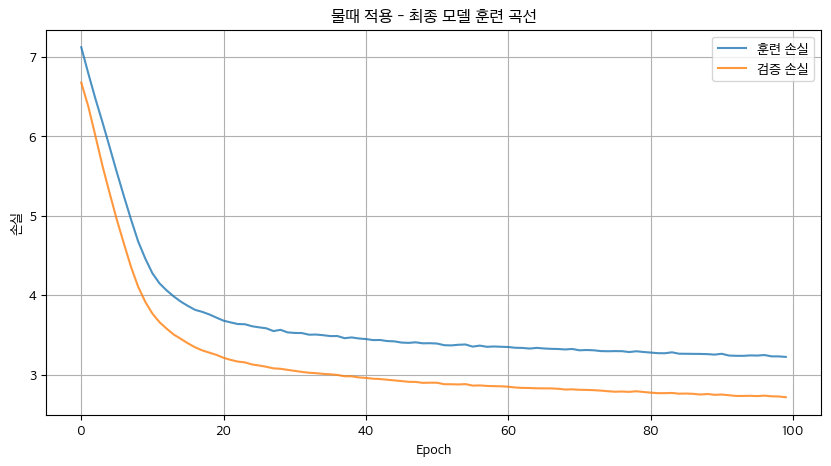


테스트 데이터 평가 시작

물때 적용 - 최종 성능 요약
테스트 데이터 평균 재구성 오차 (MSE): 0.216125
테스트 데이터 평균 KL 손실: 4.452420
테스트 데이터 평균 ELBO: 2.797770
이상치 탐지 임계값 (95 퍼센타일): 5.780271
탐지된 이상치 수: 18/343 (5.25%)

샘플 ELBO 점수 (처음 5개):
  테스트 #1 -> ELBO: 2.6659, 점수: 0.8238
  테스트 #2 -> ELBO: 3.2589, 점수: 0.7627
  테스트 #3 -> ELBO: 6.2692, 점수: 0.4525
  테스트 #4 -> ELBO: 5.4528, 점수: 0.5366
  테스트 #5 -> ELBO: 3.0021, 점수: 0.7892


/var/folders/9g/km8p2t5105l95qr48nycb7xh0000gn/T/ipykernel_3922/806145218.py:1009: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Apple SD Gothic Neo.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniforge/base/envs/311/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Apple SD Gothic Neo.
  fig.canvas.print_figure(bytes_io, **kw)


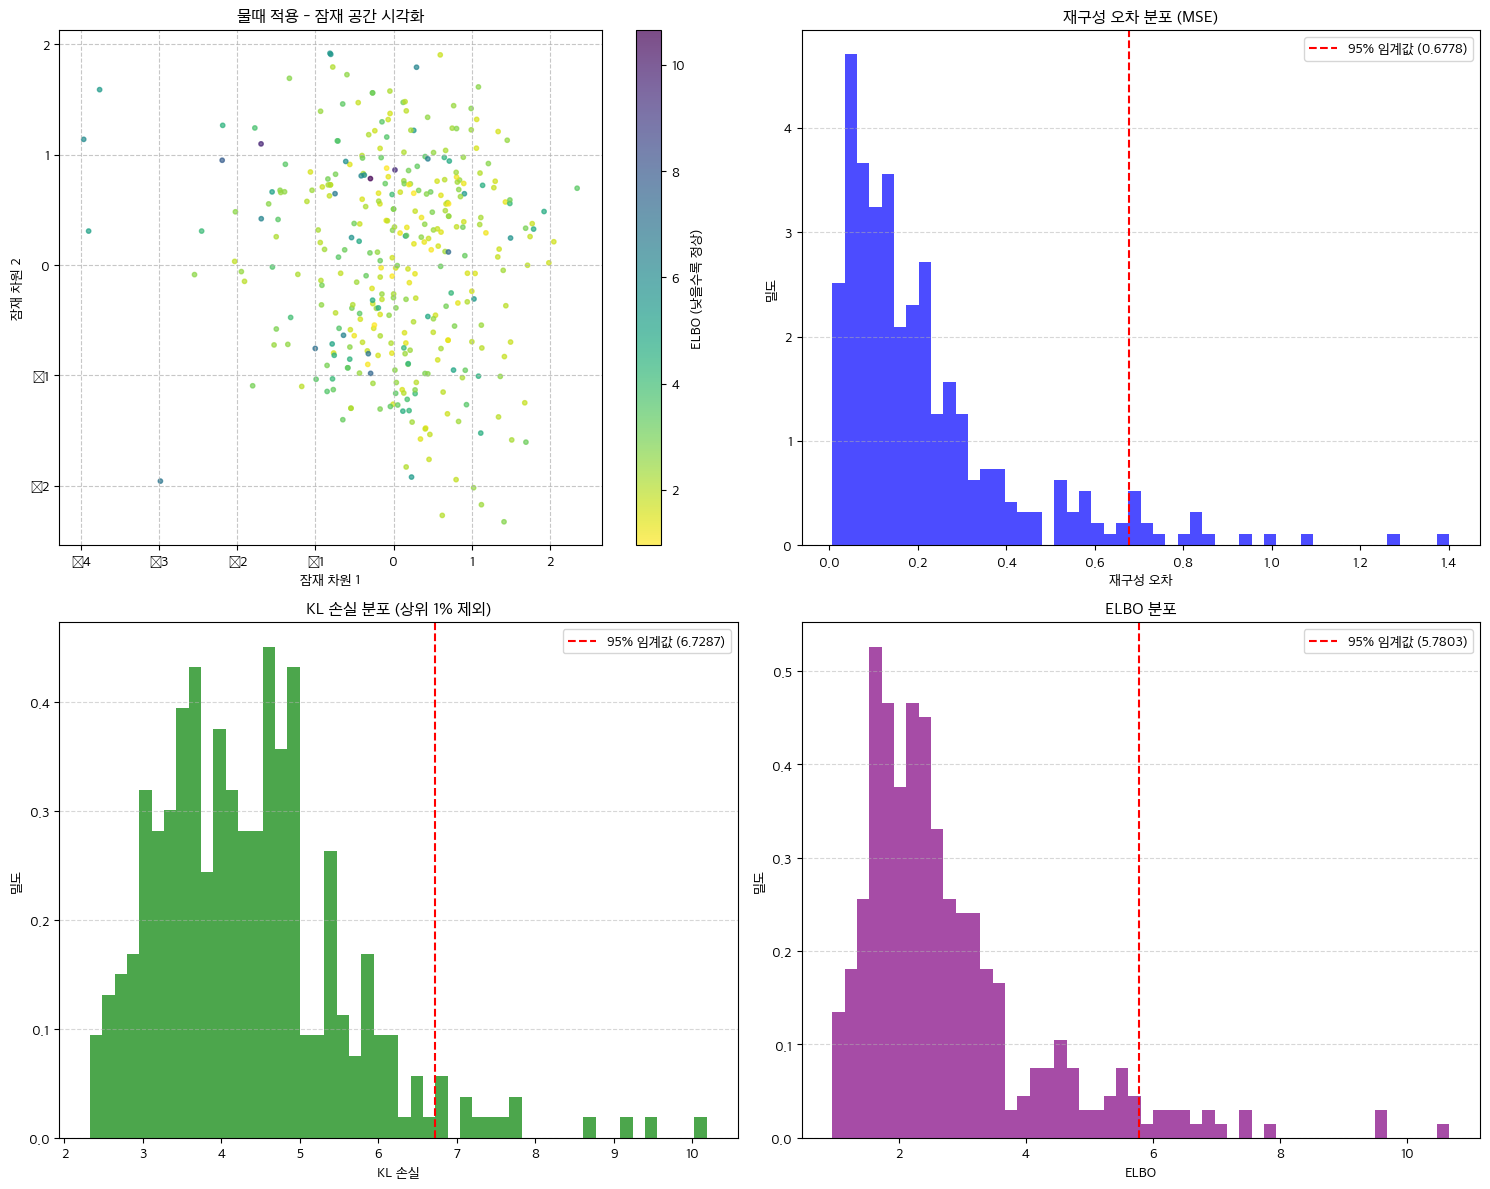


모델 저장 완료:
  - 모델: ./models/물때 적용_vae_model.pth
  - 전처리 객체: ./models/물때 적용_imputer.pkl, ./models/물때 적용_scaler.pkl
  - 결과 파일: ./result_물때 적용.csv

4/7 실험 진행 중...
한국어 폰트 'Apple SD Gothic Neo' 설정 완료

VAE 이상 탐지 분석 시작: 물때 sin/cos 인코딩
사용 피처: ['tmp_x_sea_temp', 'ws_x_wh_sig', 'weather_REH', 'wvprd_max', 'wvdr', 'wd', 'mul_tte_code_sin', 'mul_tte_code_cos']
가중치 사용: True
데이터 형태 - 훈련: (6504, 8), 테스트: (343, 8)
사용 디바이스: cpu

피처별 가중치:
  tmp_x_sea_temp: 0.7517
  ws_x_wh_sig: 1.2788
  weather_REH: 1.0321
  wvprd_max: 0.7943
  wvdr: 1.0786
  wd: 0.6929
  mul_tte_code_sin: 1.2357
  mul_tte_code_cos: 1.1359

K-Fold 교차 검증 시작 (k=3)

--- Fold 1 / 3 ---
  Epoch 20/100 - Train: 4.7558, Val: 4.2956
  Epoch 40/100 - Train: 4.1410, Val: 3.7099
  Epoch 60/100 - Train: 3.9777, Val: 3.5381
  Epoch 80/100 - Train: 3.9016, Val: 3.4434
  Epoch 100/100 - Train: 3.8463, Val: 3.3939
  Fold 1 검증 재구성 오차: 0.275717

--- Fold 2 / 3 ---
  Epoch 20/100 - Train: 4.9232, Val: 4.2670
  Epoch 40/100 - Train: 4.4958, Val: 3.8594
  E

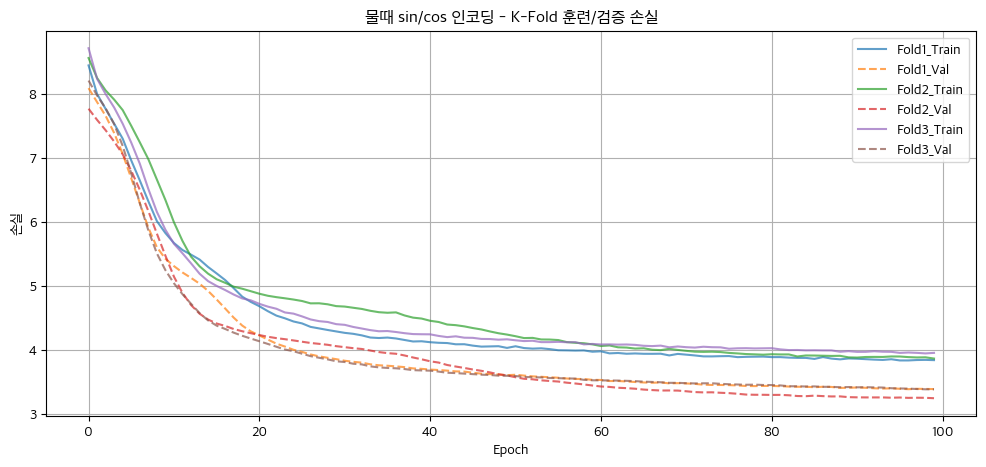


최종 모델 훈련 시작
  Epoch 20/100 - Train: 4.4205, Val: 3.7875
  Epoch 40/100 - Train: 4.0762, Val: 3.5060
  Epoch 60/100 - Train: 3.9000, Val: 3.3453
  Epoch 80/100 - Train: 3.8402, Val: 3.2813
  Epoch 100/100 - Train: 3.7956, Val: 3.2423


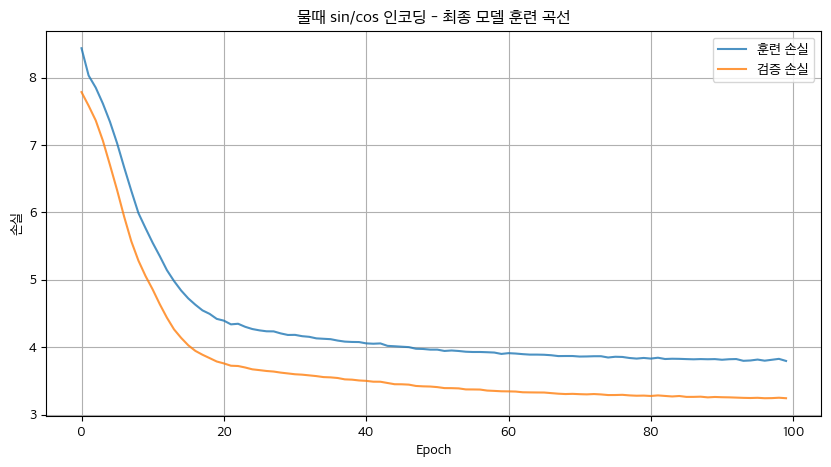


테스트 데이터 평가 시작

물때 sin/cos 인코딩 - 최종 성능 요약
테스트 데이터 평균 재구성 오차 (MSE): 0.286238
테스트 데이터 평균 KL 손실: 4.719714
테스트 데이터 평균 ELBO: 3.370847
이상치 탐지 임계값 (95 퍼센타일): 6.548617
탐지된 이상치 수: 18/343 (5.25%)

샘플 ELBO 점수 (처음 5개):
  테스트 #1 -> ELBO: 5.1530, 점수: 0.6432
  테스트 #2 -> ELBO: 4.9334, 점수: 0.6631
  테스트 #3 -> ELBO: 7.0950, 점수: 0.4669
  테스트 #4 -> ELBO: 4.9711, 점수: 0.6597
  테스트 #5 -> ELBO: 3.0439, 점수: 0.8346


/var/folders/9g/km8p2t5105l95qr48nycb7xh0000gn/T/ipykernel_3922/806145218.py:1009: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Apple SD Gothic Neo.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniforge/base/envs/311/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Apple SD Gothic Neo.
  fig.canvas.print_figure(bytes_io, **kw)


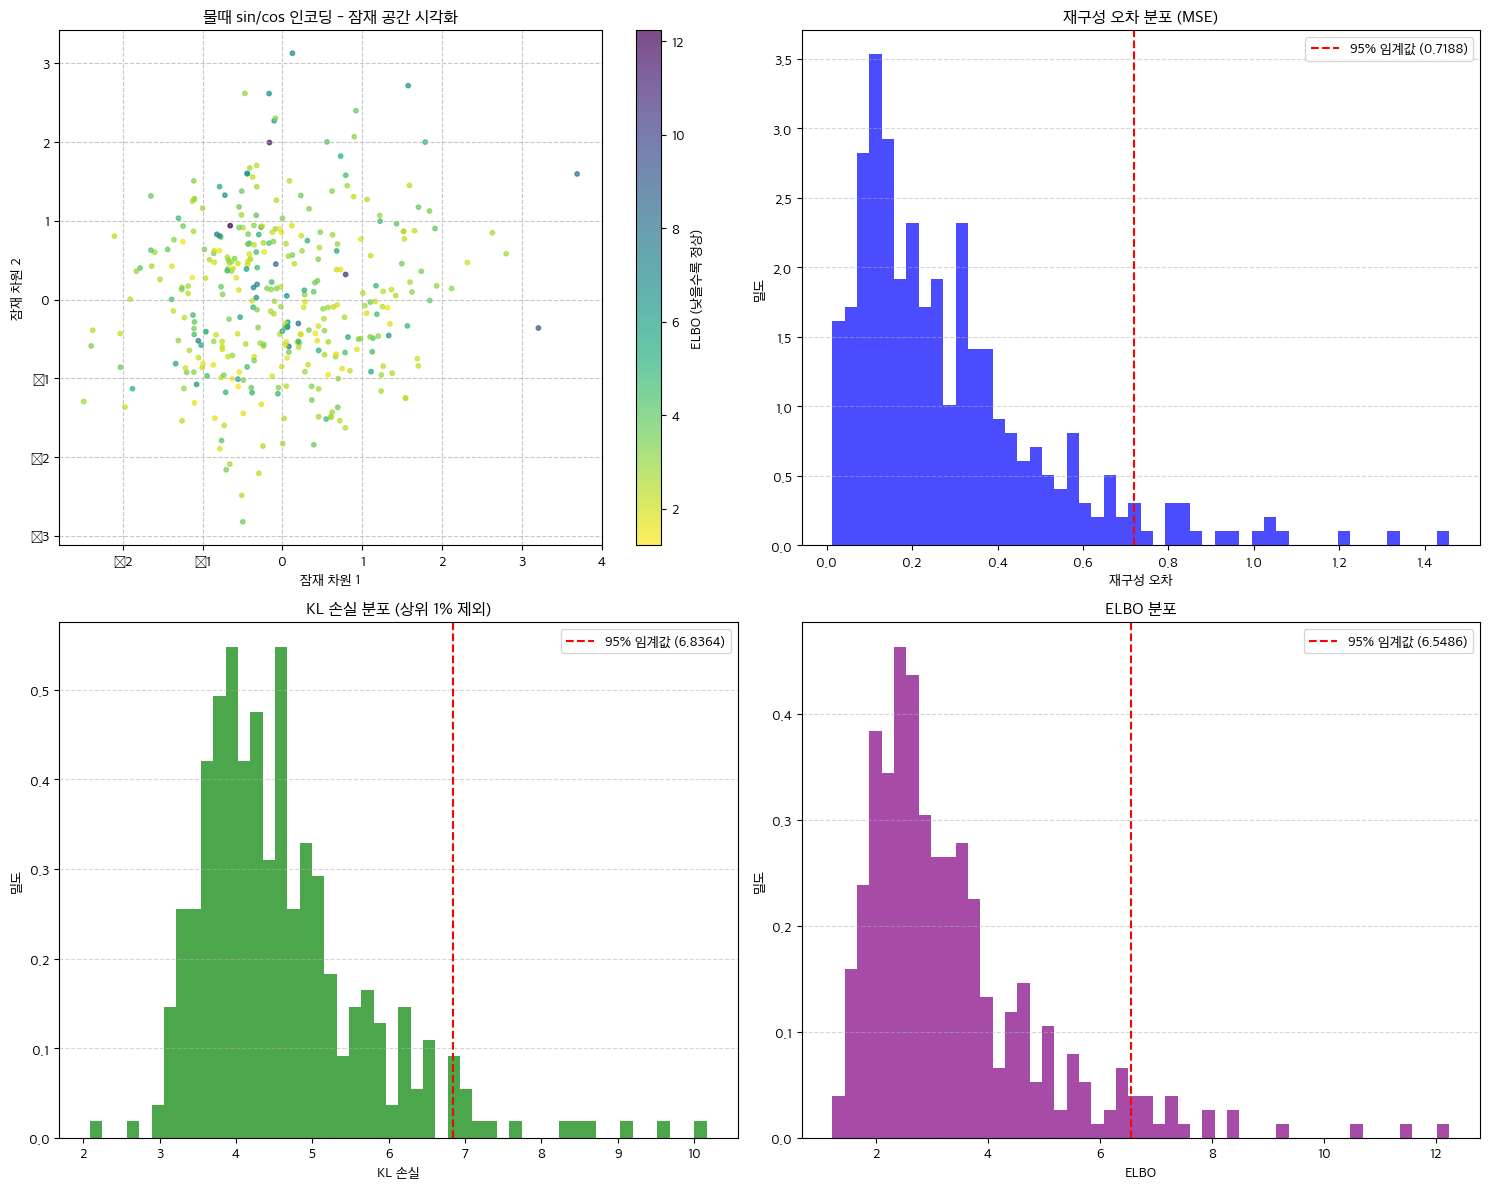

실험 물때 sin/cos 인코딩 실행 중 오류: [Errno 2] No such file or directory: './models/물때 sin/cos 인코딩_vae_model.pth'

5/7 실험 진행 중...
한국어 폰트 'Apple SD Gothic Neo' 설정 완료

VAE 이상 탐지 분석 시작: 계절 추가
사용 피처: ['tmp_x_sea_temp', 'ws_x_wh_sig', 'weather_REH', 'wvprd_max', 'wvdr', 'wd', 'mul_tte_code_sin', 'mul_tte_code_cos', 'season_sin', 'season_cos']
가중치 사용: True
데이터 형태 - 훈련: (6504, 10), 테스트: (343, 10)
사용 디바이스: cpu

피처별 가중치:
  tmp_x_sea_temp: 0.7608
  ws_x_wh_sig: 0.8548
  weather_REH: 0.7716
  wvprd_max: 0.9019
  wvdr: 1.1501
  wd: 0.9740
  mul_tte_code_sin: 1.2113
  mul_tte_code_cos: 1.3085
  season_sin: 1.1780
  season_cos: 0.8891

K-Fold 교차 검증 시작 (k=3)

--- Fold 1 / 3 ---
  Epoch 20/100 - Train: 6.2227, Val: 5.8585
  Epoch 40/100 - Train: 5.5988, Val: 5.2090
  Epoch 60/100 - Train: 5.3214, Val: 4.9332
  Epoch 80/100 - Train: 5.2110, Val: 4.8012
  Epoch 100/100 - Train: 5.0789, Val: 4.6822
  Fold 1 검증 재구성 오차: 0.327099

--- Fold 2 / 3 ---
  Epoch 20/100 - Train: 6.7278, Val: 5.8960
  Epoch 40/100 - Train: 

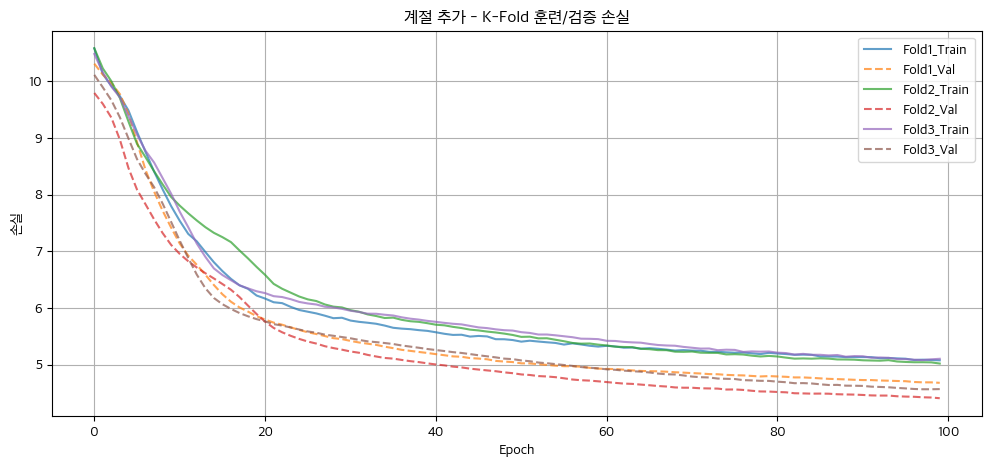


최종 모델 훈련 시작
  Epoch 20/100 - Train: 6.1033, Val: 5.5166
  Epoch 40/100 - Train: 5.6344, Val: 5.1110
  Epoch 60/100 - Train: 5.3645, Val: 4.8631
  Epoch 80/100 - Train: 5.1293, Val: 4.5736
  Epoch 100/100 - Train: 4.8683, Val: 4.3084


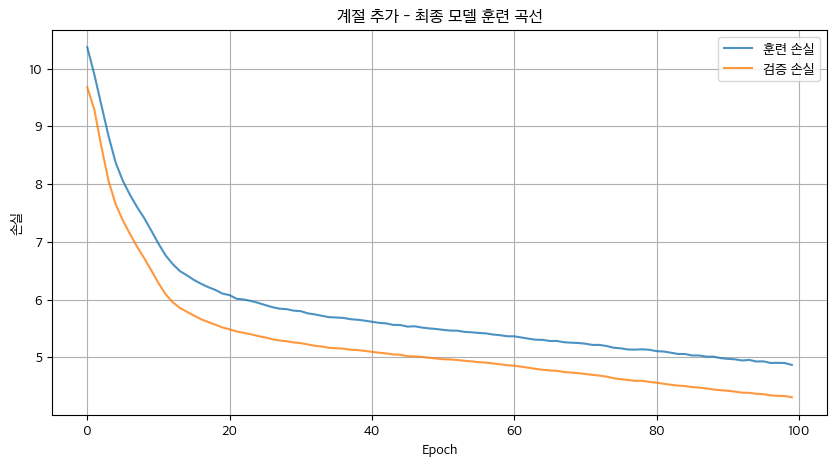


테스트 데이터 평가 시작

계절 추가 - 최종 성능 요약
테스트 데이터 평균 재구성 오차 (MSE): 0.309689
테스트 데이터 평균 KL 손실: 5.424644
테스트 데이터 평균 ELBO: 4.588204
이상치 탐지 임계값 (95 퍼센타일): 9.575628
탐지된 이상치 수: 18/343 (5.25%)

샘플 ELBO 점수 (처음 5개):
  테스트 #1 -> ELBO: 5.7641, 점수: 0.8721
  테스트 #2 -> ELBO: 5.6958, 점수: 0.8742
  테스트 #3 -> ELBO: 6.4726, 점수: 0.8503
  테스트 #4 -> ELBO: 5.7063, 점수: 0.8739
  테스트 #5 -> ELBO: 5.9973, 점수: 0.8650


/var/folders/9g/km8p2t5105l95qr48nycb7xh0000gn/T/ipykernel_3922/806145218.py:1009: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Apple SD Gothic Neo.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniforge/base/envs/311/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Apple SD Gothic Neo.
  fig.canvas.print_figure(bytes_io, **kw)


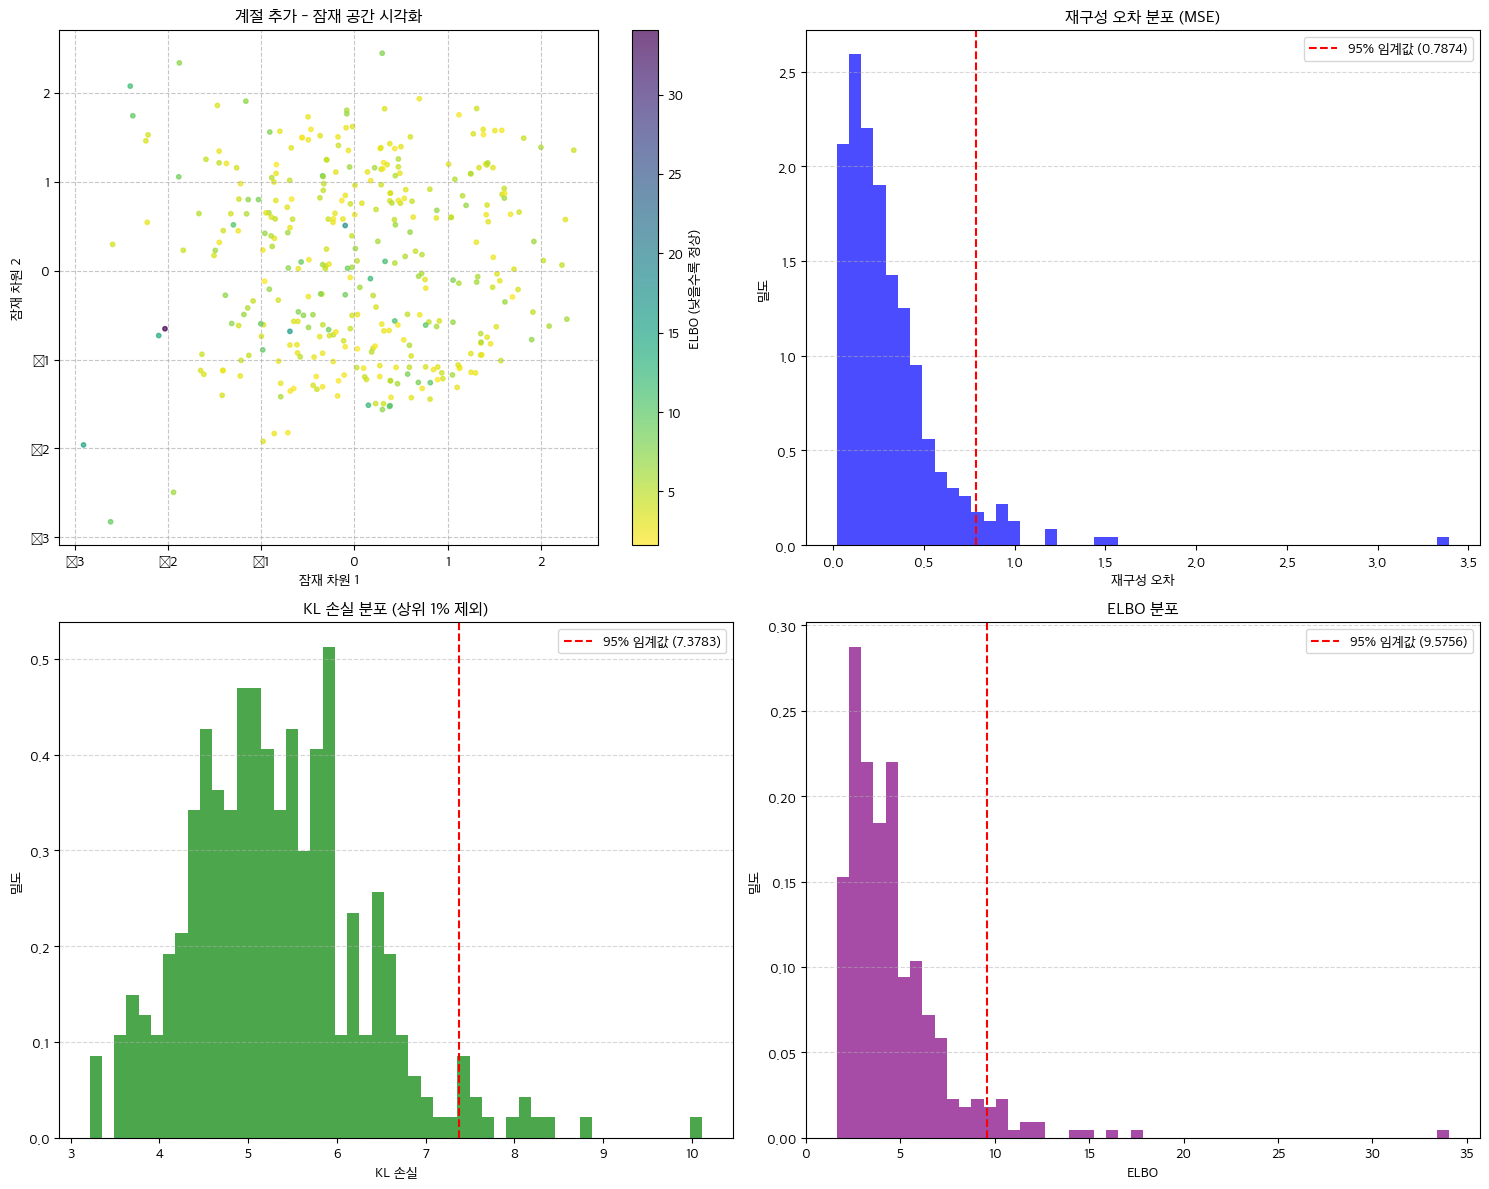


모델 저장 완료:
  - 모델: ./models/계절 추가_vae_model.pth
  - 전처리 객체: ./models/계절 추가_imputer.pkl, ./models/계절 추가_scaler.pkl
  - 결과 파일: ./result_계절 추가.csv

6/7 실험 진행 중...
한국어 폰트 'Apple SD Gothic Neo' 설정 완료

VAE 이상 탐지 분석 시작: 시간대 추가물때 제거
사용 피처: ['tmp_x_sea_temp', 'ws_x_wh_sig', 'weather_REH', 'wvprd_max', 'wvdr', 'wd', 'mul_tte_code_sin', 'mul_tte_code_cos', 'season_sin', 'season_cos', 'time_period_sin', 'time_period_cos']
가중치 사용: True
데이터 형태 - 훈련: (6504, 12), 테스트: (343, 12)
사용 디바이스: cpu

피처별 가중치:
  tmp_x_sea_temp: 1.0245
  ws_x_wh_sig: 0.9684
  weather_REH: 1.1132
  wvprd_max: 1.0047
  wvdr: 1.1646
  wd: 1.0383
  mul_tte_code_sin: 0.9212
  mul_tte_code_cos: 0.5742
  season_sin: 1.1567
  season_cos: 1.1138
  time_period_sin: 0.7027
  time_period_cos: 1.2177

K-Fold 교차 검증 시작 (k=3)

--- Fold 1 / 3 ---
  Epoch 20/100 - Train: 7.6013, Val: 7.1600
  Epoch 40/100 - Train: 7.0028, Val: 6.5763
  Epoch 60/100 - Train: 6.7911, Val: 6.3579
  Epoch 80/100 - Train: 6.6351, Val: 6.1915
  Epoch 100/100 - Train: 6

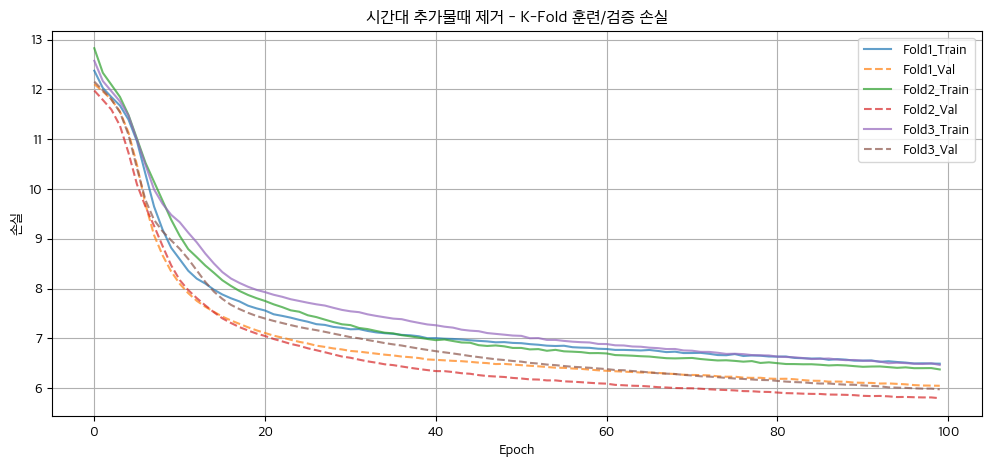


최종 모델 훈련 시작
  Epoch 20/100 - Train: 7.3323, Val: 6.7448
  Epoch 40/100 - Train: 6.7738, Val: 6.2539
  Epoch 60/100 - Train: 6.5885, Val: 6.0856
  Epoch 80/100 - Train: 6.4262, Val: 5.9276
  Epoch 100/100 - Train: 6.2662, Val: 5.7788


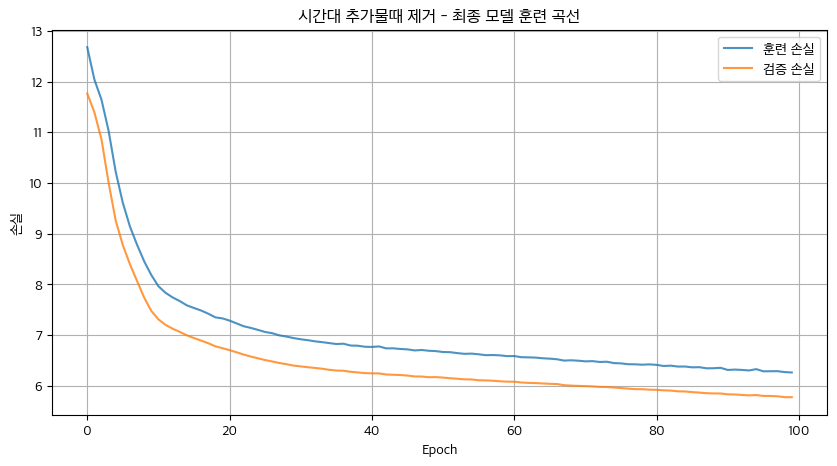


테스트 데이터 평가 시작

시간대 추가물때 제거 - 최종 성능 요약
테스트 데이터 평균 재구성 오차 (MSE): 0.415060
테스트 데이터 평균 KL 손실: 5.433346
테스트 데이터 평균 ELBO: 6.025601
이상치 탐지 임계값 (95 퍼센타일): 11.398485
탐지된 이상치 수: 18/343 (5.25%)

샘플 ELBO 점수 (처음 5개):
  테스트 #1 -> ELBO: 6.9068, 점수: 0.7004
  테스트 #2 -> ELBO: 7.4382, 점수: 0.6638
  테스트 #3 -> ELBO: 8.7808, 점수: 0.5711
  테스트 #4 -> ELBO: 8.4536, 점수: 0.5937
  테스트 #5 -> ELBO: 6.4232, 점수: 0.7338


/var/folders/9g/km8p2t5105l95qr48nycb7xh0000gn/T/ipykernel_3922/806145218.py:1009: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Apple SD Gothic Neo.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniforge/base/envs/311/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Apple SD Gothic Neo.
  fig.canvas.print_figure(bytes_io, **kw)


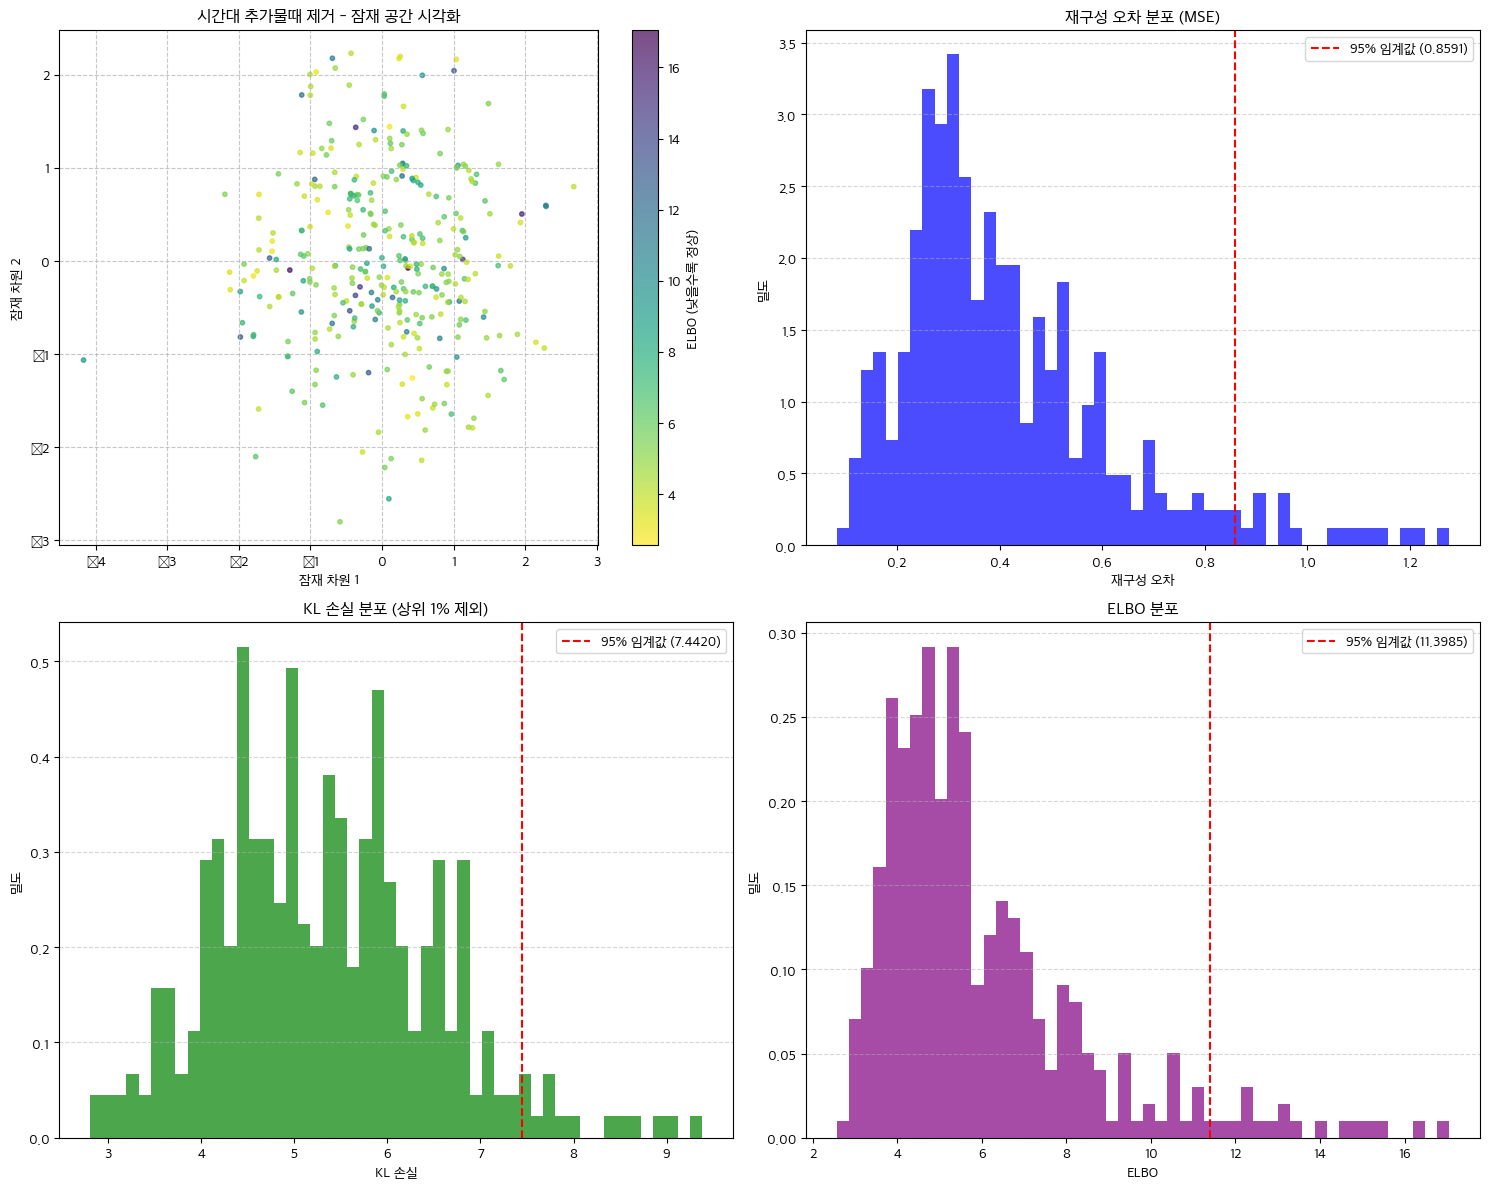


모델 저장 완료:
  - 모델: ./models/시간대 추가물때 제거_vae_model.pth
  - 전처리 객체: ./models/시간대 추가물때 제거_imputer.pkl, ./models/시간대 추가물때 제거_scaler.pkl
  - 결과 파일: ./result_시간대 추가물때 제거.csv

실험 결과 비교
                             실험명                                                                                                                                                                                 피처 조합  피처 수  평균 재구성 오차  평균 KL 손실  평균 ELBO  이상치 수  이상치 비율(%)
corr + VIF 점수 기반 변수 삭제 후 선택된 변수들                                                                                         ['weather_TMP', 'matched_sea_temp', 'ws', 'wh_sig', 'weather_REH', 'wvprd_max', 'wvdr', 'wd']     8   0.178715  4.908630 2.886108     18   5.247813
                     상호 작용 변수 생성                                                                                                           ['tmp_x_sea_temp', 'ws_x_wh_sig', 'weather_REH', 'wvprd_max', 'wvdr', 'wd']     6   0.132543  4.294357 2.043138     18   5.247813
               

In [19]:

df = pd.read_csv("../data/final_fish_data.csv")

df["tmp_x_sea_temp"] = df["weather_TMP"] * df["matched_sea_temp"]
df["ws_x_wh_sig"] = df["ws"] * df["wh_sig"]

df['mul_tte_code'] = df['mul_tte_code'].replace(-1, 0)

df['mul_tte_code_sin'] = np.sin(2 * np.pi * df['mul_tte_code'] / 14)
df['mul_tte_code_cos'] = np.cos(2 * np.pi * df['mul_tte_code'] / 14)

df['fishing_datetime'] = pd.to_datetime(df['fishing_datetime_utc'])
df['month'] = df['fishing_datetime'].dt.month
df['hour'] = df['fishing_datetime'].dt.hour

df['season'] = df['month'].apply(lambda x: 1 if 3 <= x <= 5 else 
                                            2 if 6 <= x <= 8 else 
                                            3 if 9 <= x <= 11 else 4)

df['season_sin'] = np.sin(2 * np.pi * df['season'] / 4)
df['season_cos'] = np.cos(2 * np.pi * df['season'] / 4)

df['time_period'] = df['hour'].apply(
    lambda x: 0 if 0 <= x < 6 else 
              1 if 6 <= x < 12 else 
              2 if 12 <= x < 18 else 
              3
)

df['time_period_sin'] = np.sin(2 * np.pi * df['time_period'] / 4)
df['time_period_cos'] = np.cos(2 * np.pi * df['time_period'] / 4)

feature_combinations = [
    
    # 원본 변수들
    ["weather_TMP", "matched_sea_temp", "ws", "wh_sig", "weather_REH", "wvprd_max" , "wvdr", "wd"],
    
    # 상호 작용 변수 생성
    ["tmp_x_sea_temp", "ws_x_wh_sig", "weather_REH", "wvprd_max", "wvdr", "wd"],
    
    # 물때 적용
    ["tmp_x_sea_temp", "ws_x_wh_sig", "weather_REH", "wvprd_max", "wvdr", "wd", "mul_tte_code"],
    
    # 물때 sin/cos 인코딩 적용 -> 순환 주기를 제공
    ["tmp_x_sea_temp", "ws_x_wh_sig", "weather_REH", "wvprd_max", "wvdr", "wd", "mul_tte_code_sin", "mul_tte_code_cos"],
    
    # 계절 추가 -> 계절은 순환주기로 sin/cos 인코딩
    ["tmp_x_sea_temp", "ws_x_wh_sig", "weather_REH", "wvprd_max", "wvdr", "wd", "mul_tte_code_sin", "mul_tte_code_cos", "season_sin", "season_cos"],
    
    # 시간대 추가
    ["tmp_x_sea_temp", "ws_x_wh_sig", "weather_REH", "wvprd_max", "wvdr", "wd", "mul_tte_code_sin", "mul_tte_code_cos", "season_sin", "season_cos",  "time_period_sin", "time_period_cos"],
    
    # 물때 제거
    ["tmp_x_sea_temp", "ws_x_wh_sig", "weather_REH", "wvprd_max", "wvdr", "wd", "season_sin", "season_cos",  "time_period_sin", "time_period_cos"],

]

experiment_names = [
    "corr + VIF 점수 기반 변수 삭제 후 선택된 변수들", 
    "상호 작용 변수 생성", 
    "물때 적용", 
    "물때 sin/cos 인코딩",
    "계절 추가",
    "시간대 추가"
    "물때 제거"
]


comparison_df = compare_feature_combinations(
    df=df,
    feature_combinations=feature_combinations,
    experiment_names=experiment_names
)
